In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import XGBRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# Contents:
### 1. Data Summary
- Import Libraries
- Read the data

### 2. Data Cleaning
- Correlation between features and target on heatmap
- Data Cleaning
- Remove the columns with more than half missing values
- Drop columns with most of the rows having only one category

### 3. Feature Engineering
- Create New Numerical Features
- Create New Boolean Features
- Replace ordered categories with numbers
- Create features using mathematical transformations
- Create feature using count
- Create feature using group transforms
- Impute numerical columns

### 4. Data Visualization
- Distribution of top 5 features correlated with Sales Price

### 5. Feature Selection
- Select the most correlated features to be included in the model prediction

### 6. Model Creation
- Grid Search + XGBoost
- Lasso/Ridge + Linear Regression

### 7. Training and Testing Model
- Best Parameters
- Feature Importance


In [4]:
# Read the data
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')

# Remove rows with missing target
train = train.dropna(axis=0, subset=['SalePrice'])

# Separate target from predictors
X = train.drop(['SalePrice'], axis=1)
y = train.SalePrice

In [5]:
# X, y info

In [6]:
train.shape

(2051, 80)

In [7]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

In [8]:
info = pd.DataFrame(X.dtypes, columns=['Dtype'])
info['Unique'] = X.nunique().values
info['Null'] = X.isnull().sum().values
info

Dtype  Unique  Null
PID                int64    2051     0
MS SubClass        int64      16     0
MS Zoning         object       7     0
Lot Frontage     float64     118   330
Lot Area           int64    1476     0
Street            object       2     0
Alley             object       2  1911
Lot Shape         object       4     0
Land Contour      object       4     0
Utilities         object       3     0
Lot Config        object       5     0
Land Slope        object       3     0
Neighborhood      object      28     0
Condition 1       object       9     0
Condition 2       object       8     0
Bldg Type         object       5     0
House Style       object       8     0
Overall Qual       int64      10     0
Overall Cond       int64       9     0
Year Built         int64     113     0
Year Remod/Add     int64      61     0
Roof Style        object       6     0
Roof Matl         object       6     0
Exterior 1st      object      15     0
Exterior 2nd      object      15     0
Mas Vnr Type      object       4    22
Mas Vnr Area     float64     373    22
Exter Qual        object       4     0
Exter Cond        object       5     0
Foundation        object       6     0
Bsmt Qual         object       5    55
Bsmt Cond         object       5    55
Bsmt Exposure     object       4    58
BsmtFin Type 1    object       6    55
BsmtFin SF 1     float64     821     1
BsmtFin Type 2    object       6    56
BsmtFin SF 2     float64     205     1
Bsmt Unf SF      float64     967     1
Total Bsmt SF    float64     892     1
Heating           object       5     0
Heating QC        object       5     0
Central Air       object       2     0
Electrical        object       5     0
1st Flr SF         int64     915     0
2nd Flr SF         int64     504     0
Low Qual Fin SF    int64      31     0
Gr Liv Area        int64    1053     0
Bsmt Full Bath   float64       4     2
Bsmt Half Bath   float64       3     2
Full Bath          int64       5     0
Half Bath          int64       3     0
Bedroom AbvGr      int64       8     0
Kitchen AbvGr      int64       4     0
Kitchen Qual      object       4     0
TotRms AbvGrd      int64      14     0
Functional        object       8     0
Fireplaces         int64       5     0
Fireplace Qu      object       5  1000
Garage Type       object       6   113
Garage Yr Blt    float64     100   114
Garage Finish     object       3   114
Garage Cars      float64       6     1
Garage Area      float64     514     1
Garage Qual       object       5   114
Garage Cond       object       5   114
Paved Drive       object       3     0
Wood Deck SF       int64     322     0
Open Porch SF      int64     223     0
Enclosed Porch     int64     159     0
3Ssn Porch         int64      22     0
Screen Porch       int64     100     0
Pool Area          int64      10     0
Pool QC           object       4  2042
Fence             object       4  1651
Misc Feature      object       5  1986
Misc Val           int64      28     0
Mo Sold            int64      12     0
Yr Sold            int64       5     0
Sale Type         object       9     0

In [9]:
X.dtypes.value_counts()

object     42
int64      26
float64    11
dtype: int64

In [10]:
y.describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

# Correlation between features and target on heatmap

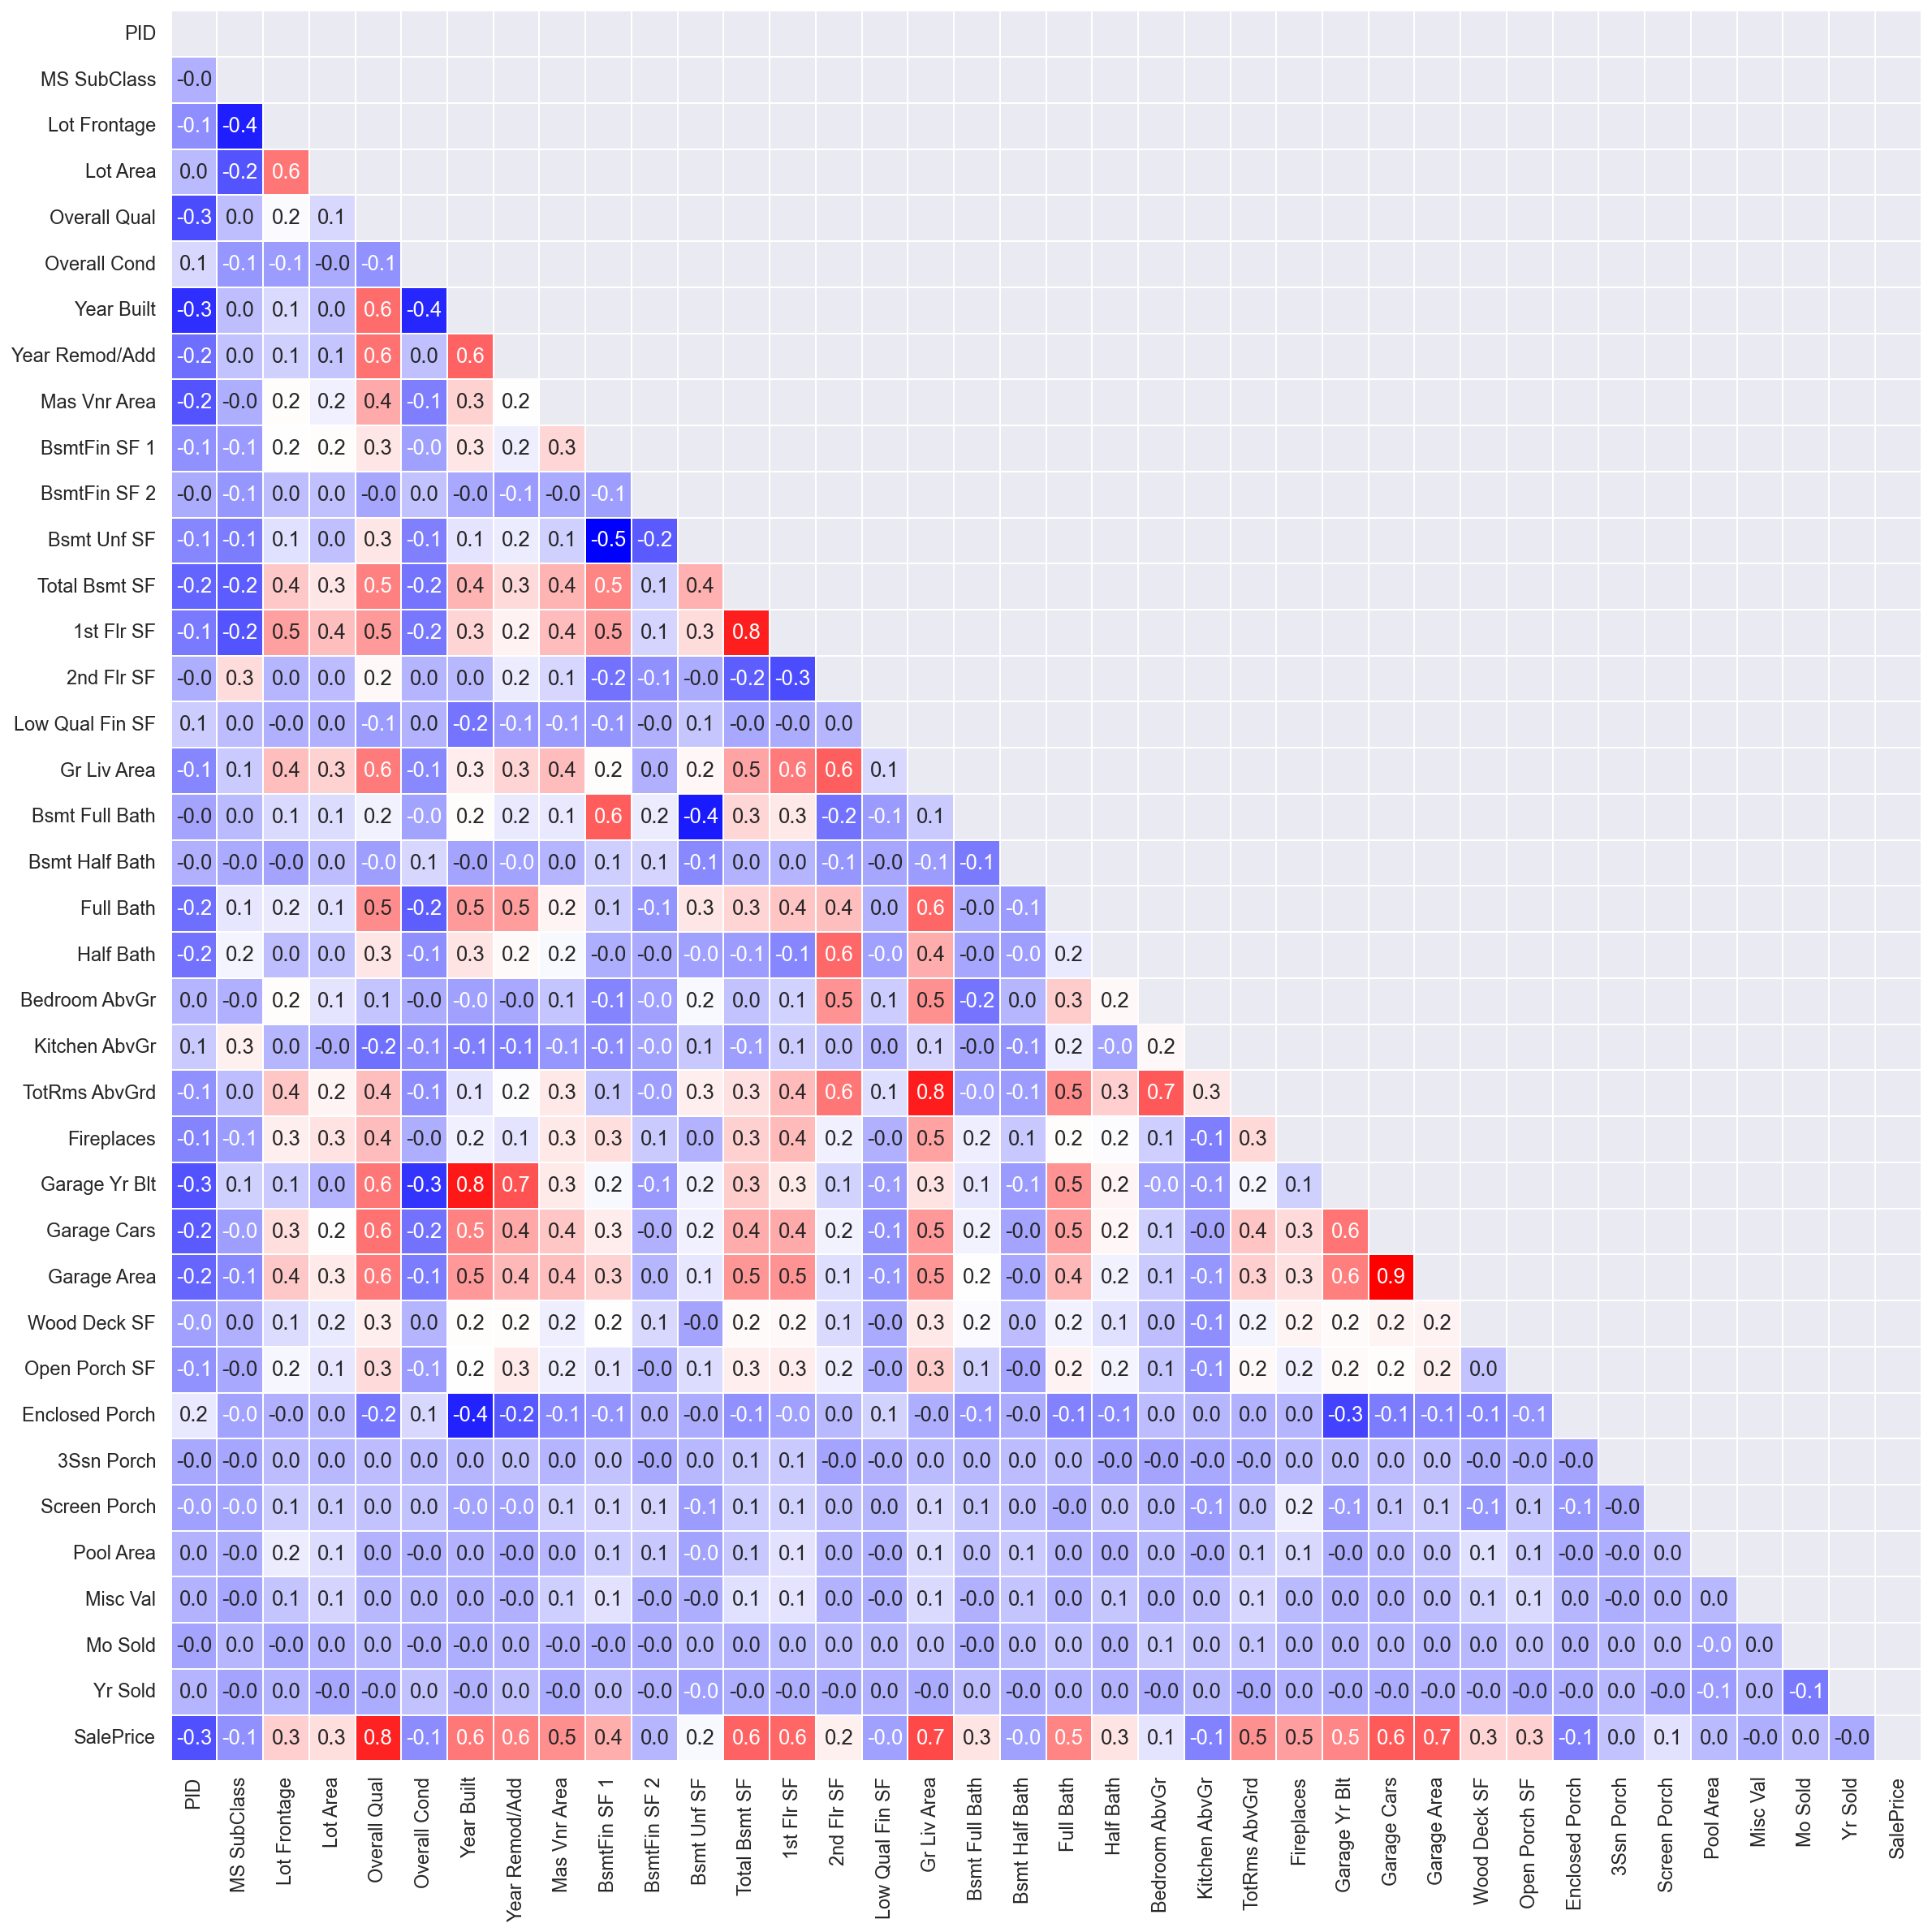

In [11]:
correlation_matrix = train.corr()

# Returns copy of array with upper part of the triangle (which will be masked/hidden)
mask = np.triu(correlation_matrix.corr())

sns.set(font_scale=1.1)
plt.figure(figsize=(20, 20), dpi=140)
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='bwr', 
            square=True, mask=mask, linewidths=1, cbar=False)
plt.show()

#plt.savefig('corr_map')

In [12]:
# Total rows/observations/houses in Training data and Test data
print(len(X),len(test))

2051 878


# Remove the columns with more than half missing values

In [13]:
# Making function so that we can reuse it in later stages as well
def show_null_values(X, test):
    # Missing values in each column of Training and Testing data
    null_values_train = X.isnull().sum()
    null_values_test = test.isnull().sum()

    # Making DataFrame for combining training and testing missing values
    null_values = pd.DataFrame(null_values_train)
    null_values['Test Data'] = null_values_test.values
    null_values.rename(columns = {0:'Train Data'}, inplace = True)

    # Showing only columns having missing values and sorting them
    null_values = null_values.loc[(null_values['Train Data']!=0) | (null_values['Test Data']!=0)]
    null_values = null_values.sort_values(by=['Train Data','Test Data'],ascending=False)
    
    print("Total missing values:",null_values.sum(),sep='\n')
    
    return null_values

In [14]:
show_null_values(X, test)

Total missing values:
Train Data    9822
Test Data     4171
dtype: int64


Train Data  Test Data
Pool QC               2042        874
Misc Feature          1986        837
Alley                 1911        820
Fence                 1651        706
Fireplace Qu          1000        422
Lot Frontage           330        160
Garage Yr Blt          114         45
Garage Finish          114         45
Garage Qual            114         45
Garage Cond            114         45
Garage Type            113         44
Bsmt Exposure           58         25
BsmtFin Type 2          56         25
Bsmt Qual               55         25
Bsmt Cond               55         25
BsmtFin Type 1          55         25
Mas Vnr Type            22          1
Mas Vnr Area            22          1
Bsmt Full Bath           2          0
Bsmt Half Bath           2          0
BsmtFin SF 1             1          0
BsmtFin SF 2             1          0
Bsmt Unf SF              1          0
Total Bsmt SF            1          0
Garage Cars              1          0
Garage Area              1          0
Electrical               0          1

In [15]:
# Columns with missing values in more than half number of rows
null_cols = [col for col in X.columns if X[col].isnull().sum() > len(X)/2]
null_cols

['Alley', 'Pool QC', 'Fence', 'Misc Feature']

In [16]:
X.drop(null_cols,axis=1,inplace=True)
test.drop(null_cols,axis=1,inplace=True)

In [17]:
# Total missing values after removing columns with more than half missing values
print("Total missing values:")
print("Training data\t",X.isnull().sum().sum())
print("Testing data\t",test.isnull().sum().sum())

Total missing values:
Training data	 2232
Testing data	 934


# Data Visualization (Categorical Data)

In [18]:
X.dtypes

PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
Bsmt Unf SF        float64
T

In [19]:
object_cols = X.select_dtypes('object').columns
len(object_cols)

38

In [20]:
from math import ceil

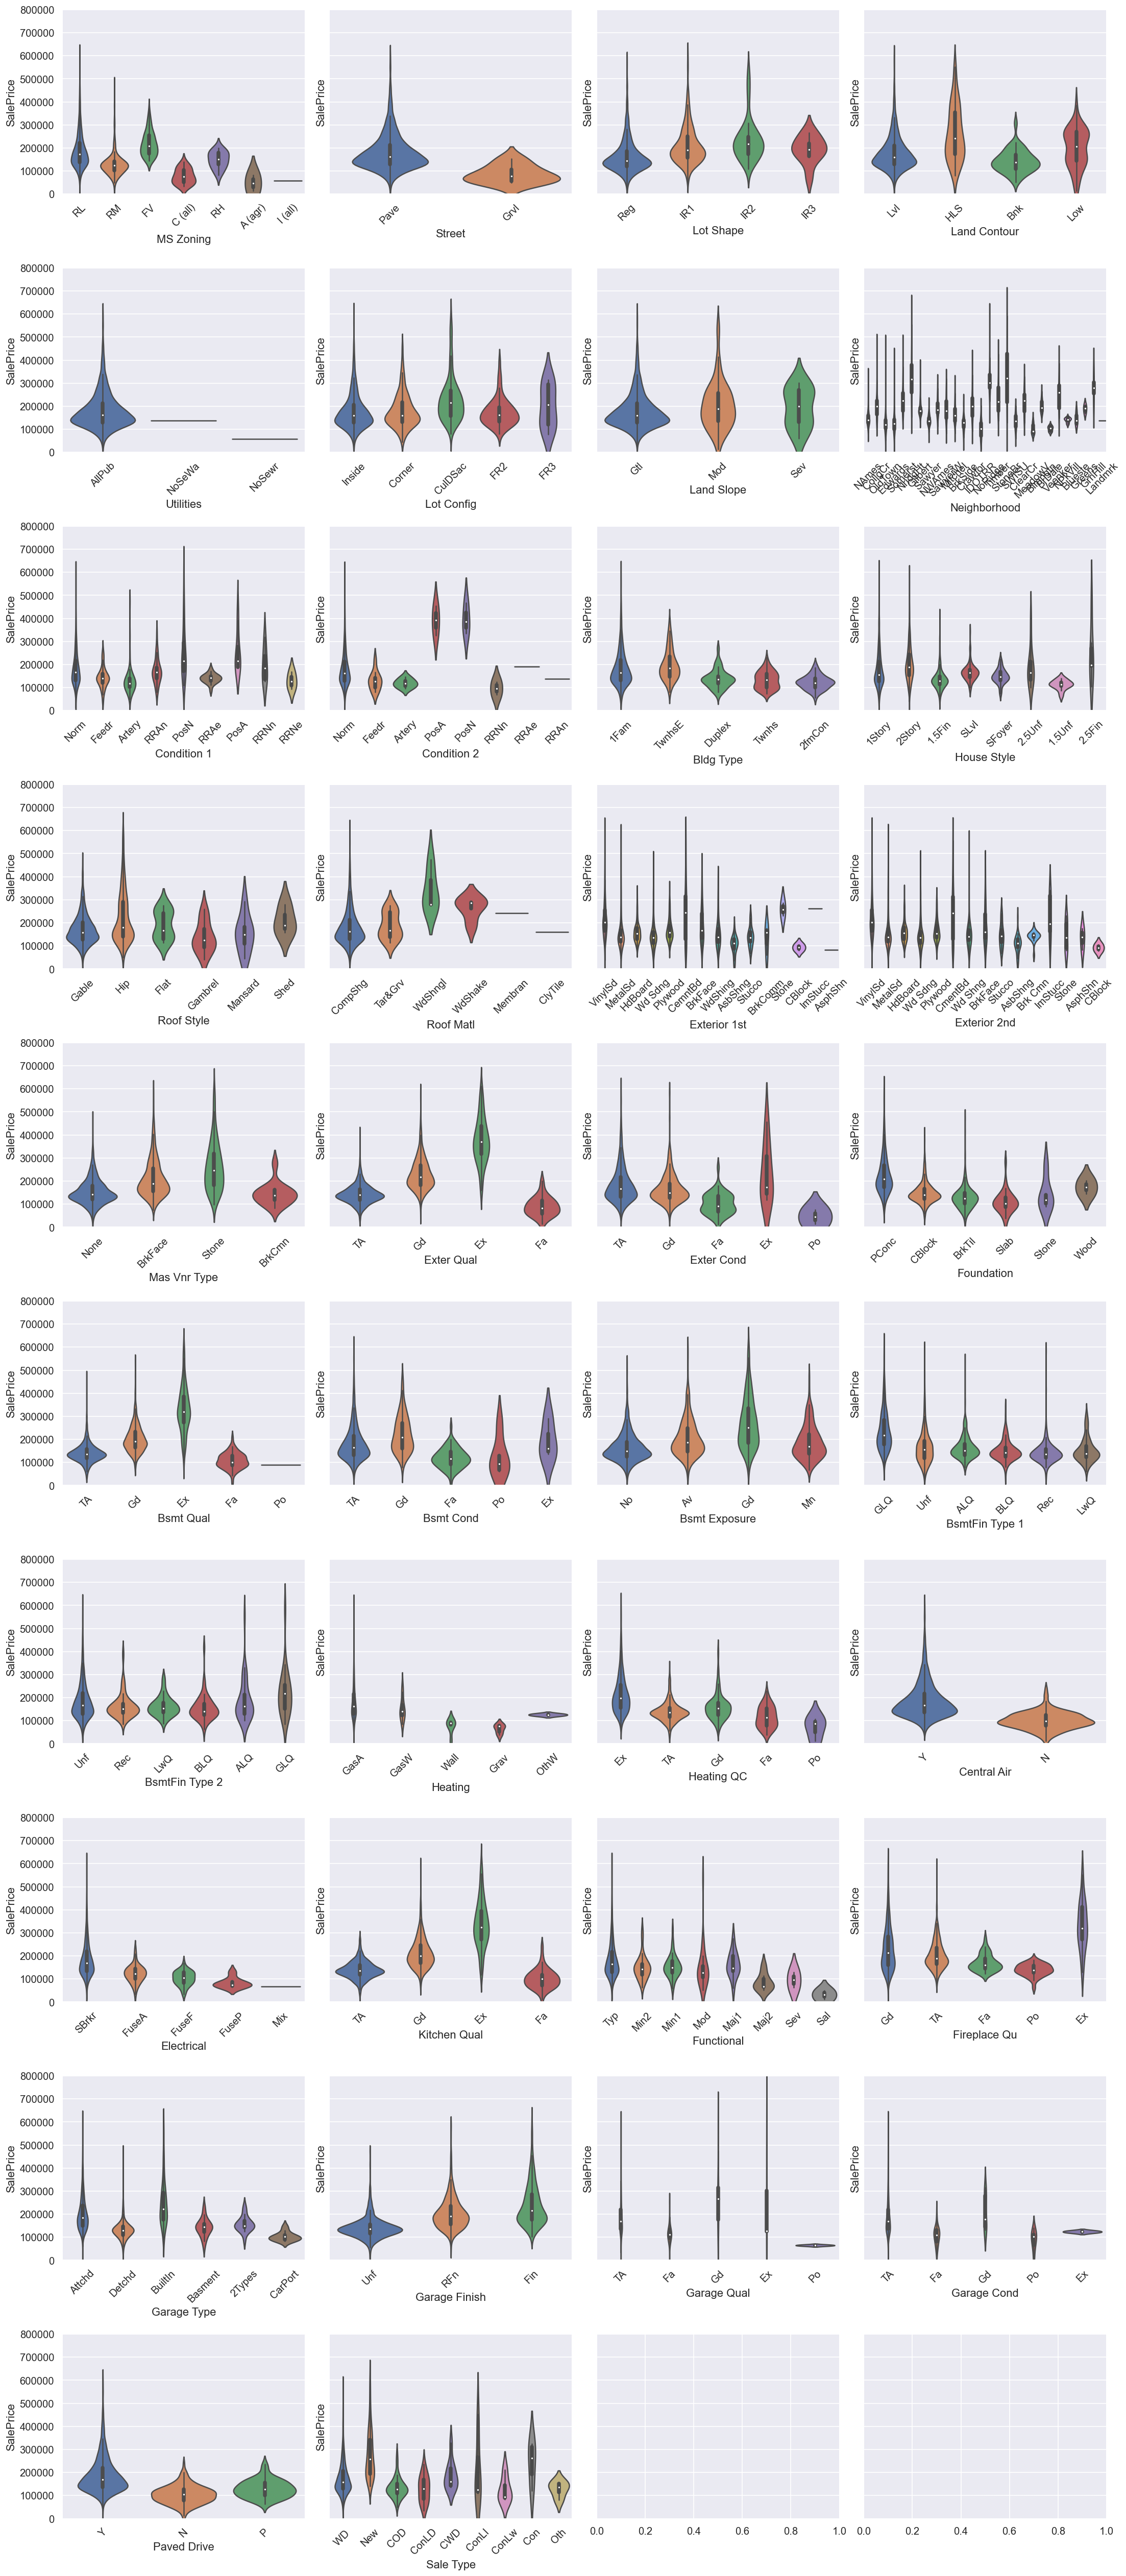

In [21]:
fig, ax = plt.subplots(nrows=ceil(len(object_cols) / 4), ncols=4, figsize=(22, 1.4*len(object_cols)), sharey=True, dpi=120)

for col, subplot in zip(object_cols, ax.flatten()):
    freq = X[col].value_counts()
    subplot.ticklabel_format(style='plain')
    plt.ylim([0, 800000])
    plt.subplots_adjust(wspace=.1,hspace=.4)
    for tick in subplot.get_xticklabels():
        tick.set_rotation(45)
    sns.violinplot(data=X, x=col, y=y, order=freq.index, ax=subplot)

# 3) Feature Engineering

In [22]:
# Merge the datasets so we can process them together
df = pd.concat([X, test])

In [23]:
df.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage

In [24]:
df.isna().sum()

PID                   0
MS SubClass           0
MS Zoning             0
Lot Frontage        490
Lot Area              0
Street                0
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Year Built            0
Year Remod/Add        0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type         23
Mas Vnr Area         23
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            80
Bsmt Cond            80
Bsmt Exposure        83
BsmtFin Type 1       80
BsmtFin SF 1          1
BsmtFin Type 2       81
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Heating               0
Heating QC            0
Central Air           0
Electrical      

# 3.1) Creating New Numerical Features - df1['Age'], df1['AgeRemodel']

In [25]:
df1 = pd.DataFrame()  # dataframe to hold new features

# Age of House when sold
df1['Age'] = df['Yr Sold']-df['Year Built']

# Years between Remodeling and sales
df1['AgeRemodel'] = df['Yr Sold']-df['Year Remod/Add']

Years = ['Yr Sold','Year Built','Year Remod/Add']
year_cols = ['Yr Sold','Year Built','AgeRemodel', 'Age']
df_1 = pd.concat([df, df1], axis=1).loc[:,year_cols]
X_1 = df_1.loc[X.index, :]
X_1.sample()

Yr Sold  Year Built  AgeRemodel  Age
Id                                        
1974     2007        1926          27   81

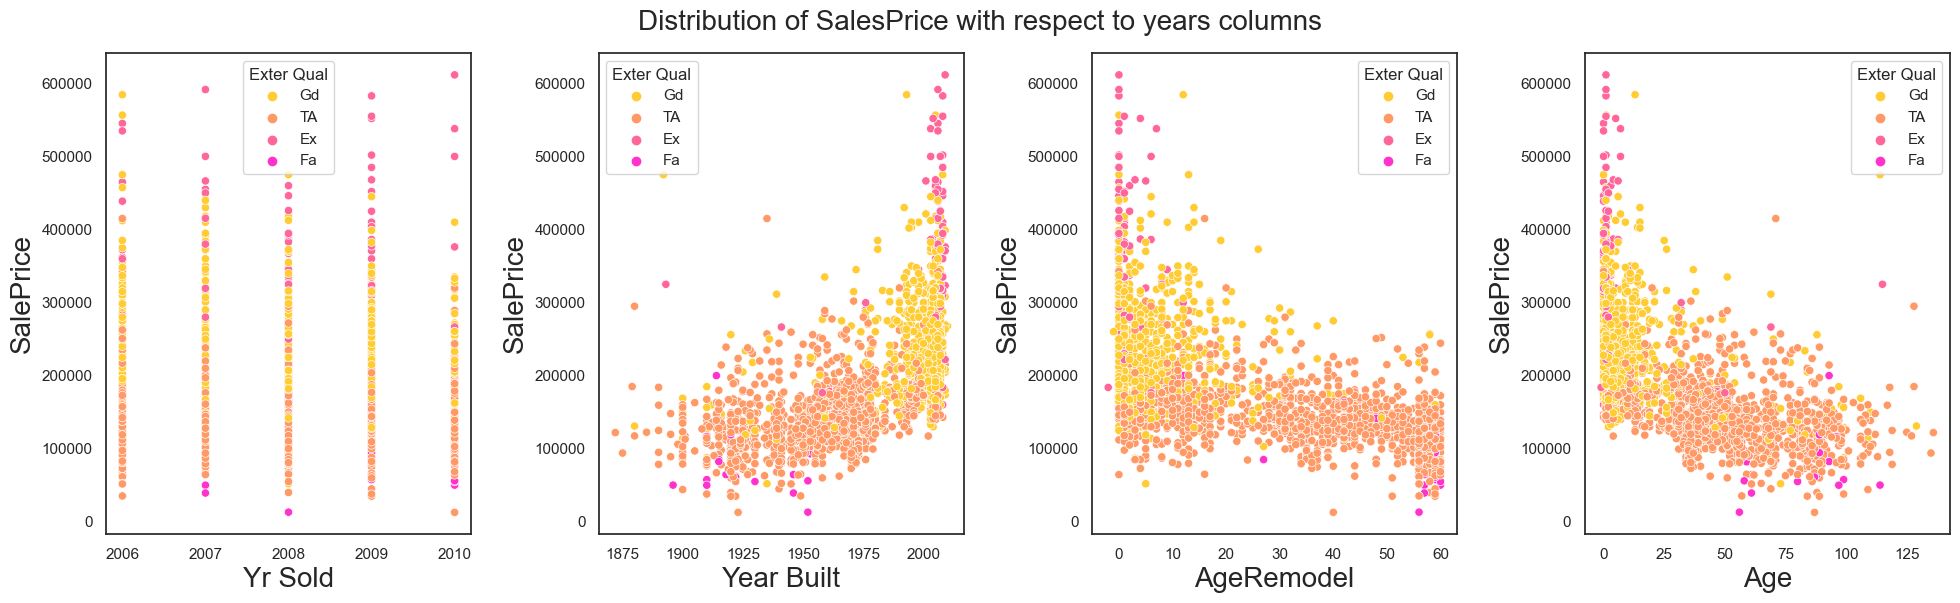

In [26]:
sns.set(style='whitegrid')
# sns.set_context("paper", rc={"font.size":20,"axes.titlesize":25,"axes.labelsize":20}) 
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
# sns.set(font_scale=1.1)
fig, ax = plt.subplots(1, 4, figsize=(20, 6), dpi=100)

# scatterplot
for col,i in zip(year_cols, [0,1,2,3]):
    sns.scatterplot(x=X_1.loc[:,col], y=y, ax=ax[i], hue=X['Exter Qual'], palette='spring_r')

fig.tight_layout()
fig.text(0.5, 1, 'Distribution of SalesPrice with respect to years columns', size=20, ha="center", va="center")
plt.show()

In [27]:
# Correlation of year columns with SalePrice
X_1.corrwith(y)

Yr Sold      -0.015203
Year Built    0.571849
AgeRemodel   -0.551716
Age          -0.571881
dtype: float64

# 3.2) Creating New Boolean Features

Remodel column:

False (for 764 houses having Remodel date same as construction date i.e. no modeling or additions)
True (for 696 houses with modeling or additions done)
Garage column:

False (for 81 rows having missing values in columns GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond)
Fireplace column:

False (for 690 rows having missing values in column FireplaceQu)
Basement column:

False (for 37 rows having missing values in columns BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2)
Masonry veneer column:

False (for 8 rows having missing values in columns MasVnrType, MasVnrArea)

In [28]:
df.dtypes.value_counts()

object     38
int64      26
float64    11
dtype: int64

In [29]:
df2 = pd.DataFrame()  # dataframe to hold new features

df2['Remodel'] = df['Year Remod/Add']!=df['Year Built']
df2['Garage'] = df['Garage Qual'].notnull()
df2['Fireplace'] = df['Fireplace Qu'].notnull()
df2['Bsmt'] = df['Bsmt Qual'].notnull()
df2['Masonry'] = df['Mas Vnr Type'].notnull()

# Converting boolean columns [False,True] into numerical columns [0,1]
df2 = df2.replace([False,True], [0,1])
df2.head()

Remodel  Garage  Fireplace  Bsmt  Masonry
Id                                            
109        1       1          0     1        1
544        1       1          1     1        1
153        1       1          0     1        1
318        1       1          0     1        1
255        1       1          0     1        1

In [30]:
object_cols = df.select_dtypes(include=['object']).columns
# Categorical Columns with number of unuque categoies in them 
df[object_cols].nunique().sort_values()

Central Air        2
Street             2
Utilities          3
Land Slope         3
Garage Finish      3
Paved Drive        3
Lot Shape          4
Land Contour       4
Bsmt Exposure      4
Exter Qual         4
Bsmt Cond          5
Bsmt Qual          5
Mas Vnr Type       5
Electrical         5
Exter Cond         5
Heating QC         5
Bldg Type          5
Garage Qual        5
Garage Cond        5
Lot Config         5
Kitchen Qual       5
Fireplace Qu       5
Roof Style         6
Garage Type        6
Foundation         6
BsmtFin Type 1     6
BsmtFin Type 2     6
Heating            6
MS Zoning          7
Functional         8
Roof Matl          8
House Style        8
Condition 2        8
Condition 1        9
Sale Type         10
Exterior 1st      16
Exterior 2nd      17
Neighborhood      28
dtype: int64

In [31]:
#pd.set_option('display.max_columns', None)
#df[df['Exter Cond'] == 2]

In [32]:
ordinal_cols = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Fin' in i) or ('Cond' in i) and ('Condition' not in i)]
df.loc[:,ordinal_cols] = df.loc[:,ordinal_cols].fillna('NA')
print("Column Names: [Unique Categories in each column]")
{col:[*df[col].unique()] for col in ordinal_cols}

Column Names: [Unique Categories in each column]


{'Exter Qual': ['Gd', 'TA', 'Ex', 'Fa'],
 'Exter Cond': ['TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'Bsmt Qual': ['TA', 'Gd', 'Fa', 'NA', 'Ex', 'Po'],
 'Bsmt Cond': ['TA', 'Gd', 'NA', 'Fa', 'Po', 'Ex'],
 'BsmtFin Type 1': ['GLQ', 'Unf', 'ALQ', 'Rec', 'NA', 'BLQ', 'LwQ'],
 'BsmtFin Type 2': ['Unf', 'Rec', 'NA', 'BLQ', 'GLQ', 'LwQ', 'ALQ'],
 'Heating QC': ['Ex', 'TA', 'Gd', 'Fa', 'Po'],
 'Kitchen Qual': ['Gd', 'TA', 'Fa', 'Ex', 'Po'],
 'Fireplace Qu': ['NA', 'TA', 'Gd', 'Po', 'Ex', 'Fa'],
 'Garage Finish': ['RFn', 'Unf', 'Fin', 'NA'],
 'Garage Qual': ['TA', 'Fa', 'NA', 'Gd', 'Ex', 'Po'],
 'Garage Cond': ['TA', 'Fa', 'NA', 'Po', 'Gd', 'Ex']}

In [33]:
# 1] Columns with similar ordered categories [Poor<Fair<Typical/Average<Good<Excellent]
ordinal_cols1 = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Cond' in i) and ('Condition' not in i)]
df.loc[:,ordinal_cols1] = df.loc[:,ordinal_cols1].replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])

# 2] Columns with similar ordered categories [No Garage/Basement<Unfinished<Rough Finished<Finished,etc]
ordinal_cols2 = ['BsmtFin Type 1', 'BsmtFin Type 2']
df.loc[:,ordinal_cols2] = df.loc[:,ordinal_cols2].replace(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [0,1,2,3,4,5,6])

# 3] Column with ordered categories [No Basement<No Exposure<Mimimum Exposure<Average Exposure<Good Exposure]
ordinal_cols3 = ['Bsmt Exposure']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('NA')
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].replace(['NA', 'No', 'Mn', 'Av', 'Gd'], [0,1,2,3,4])

# 4] Column with ordered categories [Regular<Slightly irregular<Moderately Irregular<Irregular]
ordinal_cols4 = ['Lot Shape']
df.loc[:,ordinal_cols4] = df.loc[:,ordinal_cols4].replace(['Reg', 'IR1', 'IR2', 'IR3'], [0,1,2,3])

# 5] Column with ordered categories [No Garage<Unfinished<Rough Finished<Finished]
ordinal_cols5 = ['Garage Finish']
df.loc[:,ordinal_cols5] = df.loc[:,ordinal_cols5].replace(['NA', 'Unf', 'RFn', 'Fin'], [0,1,2,3])

# 6] Home functionality Column
ordinal_cols6 = ['Functional']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('Mod')
df.loc[:,ordinal_cols6] = df.loc[:,ordinal_cols6].replace(["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"], list(range(8)))

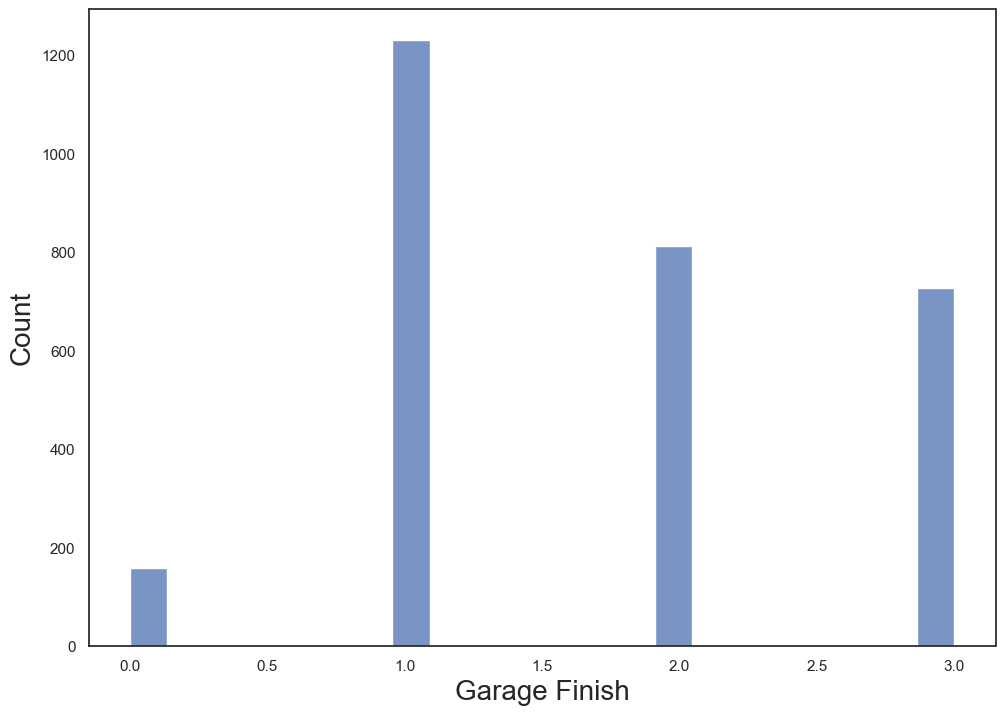

In [34]:
sns.histplot(df, x="Garage Finish");
#'Garage Finish': ['RFn', 'Unf', 'Fin', 'NA']

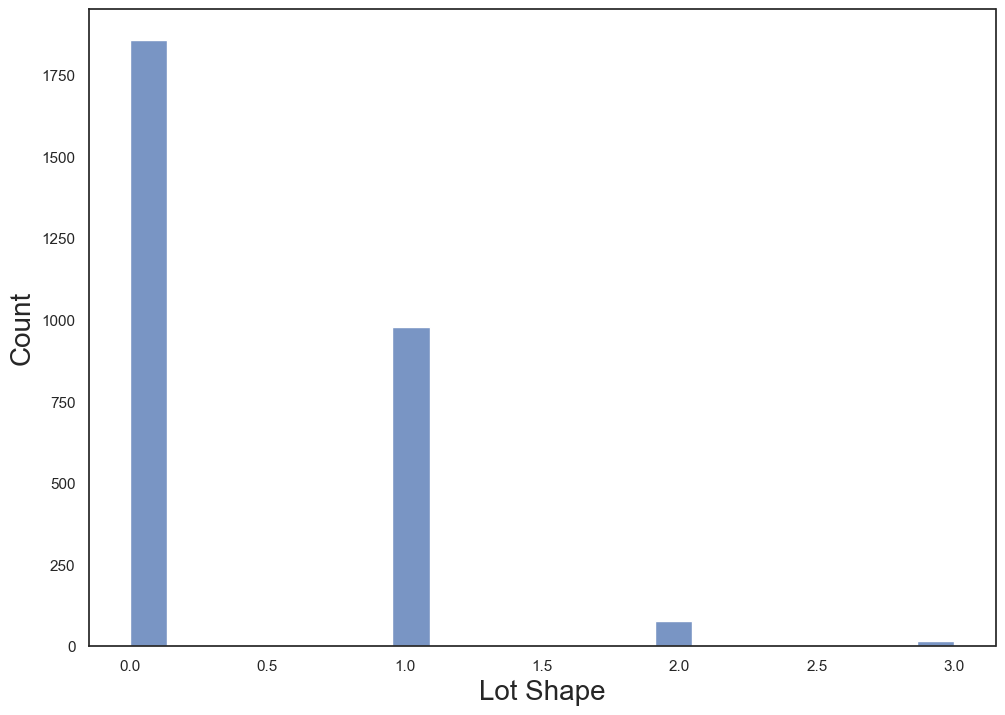

In [35]:
sns.histplot(df, x="Lot Shape", bins = 'auto', legend = True);
#BsmtFin Type 2': ['Unf', 'Rec', 'NA', 'BLQ', 'GLQ', 'LwQ', 'ALQ'],

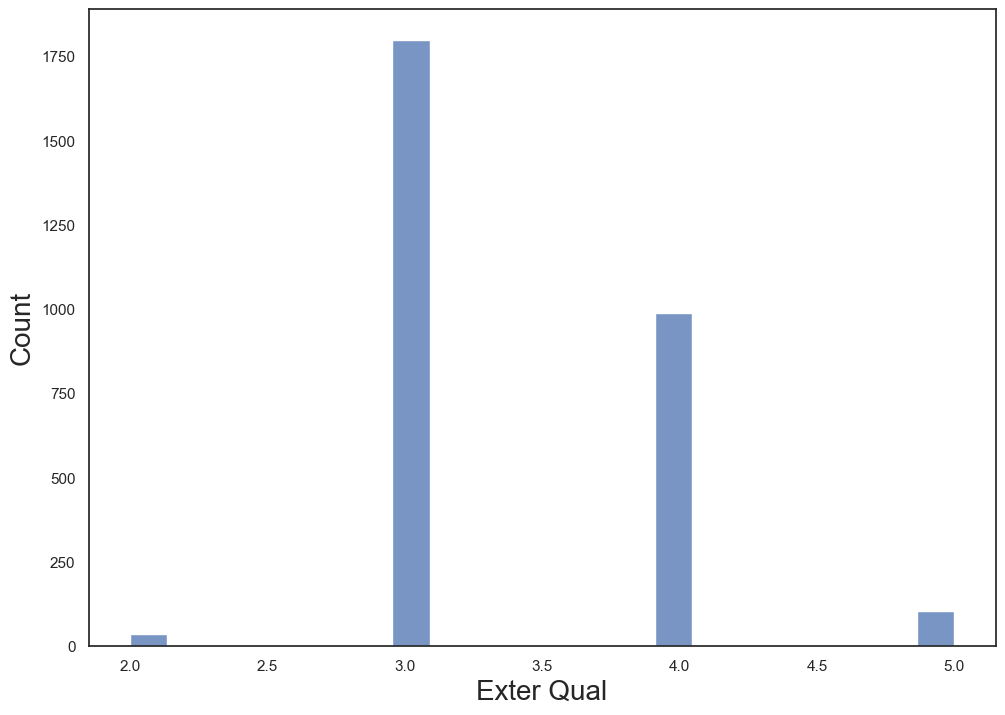

In [36]:
sns.histplot(df, x='Exter Qual');
#Exter Cond': ['TA', 'Gd', 'Fa', 'Ex', 'Po']

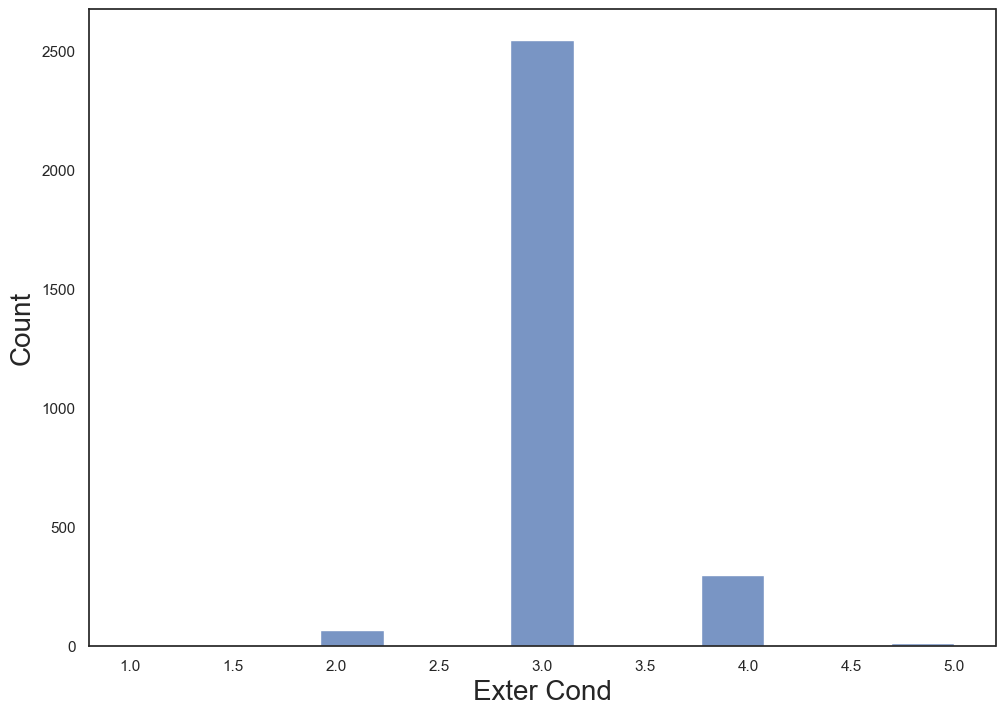

In [37]:
sns.histplot(df, x='Exter Cond');
#Exter Cond: ['TA', 'Gd', 'Fa', 'Ex', 'Po']

# 3.3 Creating features using mathematical transformations

In [38]:
Bath_cols = [i for i in df.columns if 'Bath' in i]
Bath_cols

['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath']

In [39]:
SF_cols = ['Total Bsmt SF','1st Flr SF','2nd Flr SF']
df[SF_cols+Bath_cols] = df[SF_cols+Bath_cols].fillna(0)

In [40]:
df.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage

In [41]:
df3 = pd.DataFrame()  # dataframe to hold new features

df3["Liv_Qual"] = (df['Overall Qual']  + df['Overall Cond']/3) * df['Gr Liv Area']
df3["GarageArea_Qual"] = (df['Garage Qual'] + df['Garage Cond']/3) * df['Garage Area'] * df['Garage Cars']
df3['BsmtArea_Qual'] = (df['Bsmt Qual'] * df['Bsmt Cond']/3) * df['Total Bsmt SF']
df3["LivLotRatio"] = df['Gr Liv Area'] / df['Lot Area']
df3["Spaciousness"] = (df['1st Flr SF'] + df['2nd Flr SF']) / df['TotRms AbvGrd']
df3['TotalSF'] = df[SF_cols].sum(axis = 1)
df3['TotalBath'] = df['Full Bath'] + df['Bsmt Full Bath'] + df['Half Bath']/2 + df['Bsmt Half Bath']/2

In [42]:
df3

Liv_Qual  GarageArea_Qual  BsmtArea_Qual  LivLotRatio  Spaciousness  \
Id                                                                              
109   12818.000000           3800.0    2175.000000     0.109418    246.500000   
544   18390.666667           4472.0    3652.000000     0.184650    265.250000   
153    7751.333333            984.0    3171.000000     0.133426    211.400000   
318    9626.666667           3200.0    1536.000000     0.147317    206.285714   
255   12523.333333           3872.0    1802.666667     0.101510    240.833333   
...            ...              ...            ...          ...           ...   
1662  15016.000000           3904.0    3252.000000     0.234625    234.625000   
1234  16566.666667           3840.0    3312.000000     0.135515    220.888889   
1373   8073.333333           1288.0    2856.000000     0.146788    242.200000   
1672   5184.000000           4224.0    2592.000000     0.096000    172.800000   
1939   6166.666667           1560.0    2769.000000     0.110119    185.000000   

      TotalSF  TotalBath  
Id                        
109    2204.0        2.5  
544    3035.0        3.5  
153    2114.0        2.0  
318    1828.0        2.5  
255    2121.0        2.0  
...       ...        ...  
1662   2961.0        3.5  
1234   3092.0        2.5  
1373   2163.0        1.0  
1672   1728.0        1.0  
1939   1848.0        2.0  

[2929 rows x 7 columns]

# 3.4) Creating features using count

In [43]:
df.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage

In [44]:
df4 = pd.DataFrame()

Porches = ["Wood Deck SF","Open Porch SF","Enclosed Porch","3Ssn Porch","Screen Porch"]
df4["PorchTypes"] = df[Porches].gt(0.0).sum(axis=1)

#to count the presence of each type of porch avaialble in all 5 columns

In [45]:
df4.sample()

PorchTypes
Id            
19           0

In [46]:
df = pd.concat([df,df1,df2,df3,df4], axis=1)
df.sample()

PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
Id                                                                      
1579  916386180           60        RL          81.0     12018   Pave   

      Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
Id                                                                          
1579          1          HLS    AllPub     Corner        Gtl       Timber   

     Condition 1 Condition 2 Bldg Type  ... Age  AgeRemodel  Remodel  Garage  \
Id                                      ...                                    
1579        Norm        Norm      1Fam  ...   0           0        0       1   

      Fireplace Bsmt Masonry      Liv_Qual GarageArea_Qual BsmtArea_Qual  \
Id                                                                         
1579          0    1       1  13970.666667          7992.0        3184.0   

      LivLotRatio  Spaciousness  TotalSF TotalBath  PorchTypes  
Id                                                              
1579     0.134132    268.666667   2408.0       2.5           1  

[1 rows x 90 columns]

# 4) Imputing Numerical Columns

In [47]:
my_imputer = SimpleImputer(missing_values = np.nan, strategy ='constant', fill_value=0)
 
# Fitting the data to the imputer object
imputed_X = pd.DataFrame(my_imputer.fit_transform(X))
imputed_X_test = pd.DataFrame(my_imputer.transform(test))

# Imputation removed column names and indices; put them back
imputed_X.columns = X.columns
imputed_X_test.columns = test.columns
imputed_X.index = X.index
imputed_X_test.index = test.index
 
# Using original names of DataSets
X = imputed_X
X_test = imputed_X_test

In [48]:
show_null_values(X, X_test)

Total missing values:
Train Data    0.0
Test Data     0.0
dtype: float64


Empty DataFrame
Columns: [Train Data, Test Data]
Index: []

# 4) Data Visualization + Prediction

In [49]:
X_y = X.copy()
X_y['SalesPrice'] = y 
X_y.sample()

PID MS SubClass MS Zoning Lot Frontage Lot Area Street Lot Shape  \
Id                                                                             
1140  531382090          60        RL         65.0     8453   Pave       IR1   

     Land Contour Utilities Lot Config Land Slope Neighborhood Condition 1  \
Id                                                                           
1140          Lvl    AllPub     Inside        Gtl      SawyerW        Norm   

     Condition 2 Bldg Type  ... Garage Area Garage Qual Garage Cond  \
Id                          ...                                       
1140        Norm      1Fam  ...       525.0          TA          TA   

     Paved Drive Wood Deck SF Open Porch SF Enclosed Porch 3Ssn Porch  \
Id                                                                      
1140           Y            0            70              0          0   

     Screen Porch Pool Area Misc Val Mo Sold Yr Sold Sale Type SalesPrice  
Id                                                                         
1140            0         0        0       4    2008       WD      182000  

[1 rows x 76 columns]

In [50]:
def univariate_numerical_plot(df, x):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
    
    # 0) histogram
    sns.histplot(data=df, x=x, kde=True, ax=ax[0], bins=min(df[x].nunique(),10), kde_kws={'bw_adjust':3}, hue = x, legend = False)
    sns.despine(bottom=True, left=True)
    ax[0].set_title('histogram')
    ax[0].set_xlabel(xlabel=x)
    
    # 1) box plot
    sns.boxplot(data=df, x=x, ax=ax[1], palette='rocket')
    ax[1].set_title('boxplot')
    ax[1].set_ylabel(ylabel=x)
    
    # 2) scatterplot
    sns.scatterplot(x=df[x], y=y, ax=ax[2], hue=y ,palette='rocket')
    plt.legend([],[], frameon=False)
     
    # To add border
    fig.subplots_adjust(top=0.85, bottom=0.15, left=0.2, hspace=0.8)
    fig.patch.set_linewidth(10)
    fig.patch.set_edgecolor('cornflowerblue')
    
    fig.tight_layout()
    fig.text(0.5, 1, f'Distribution of {x}', size=25, ha="center", va="center")
    plt.show()


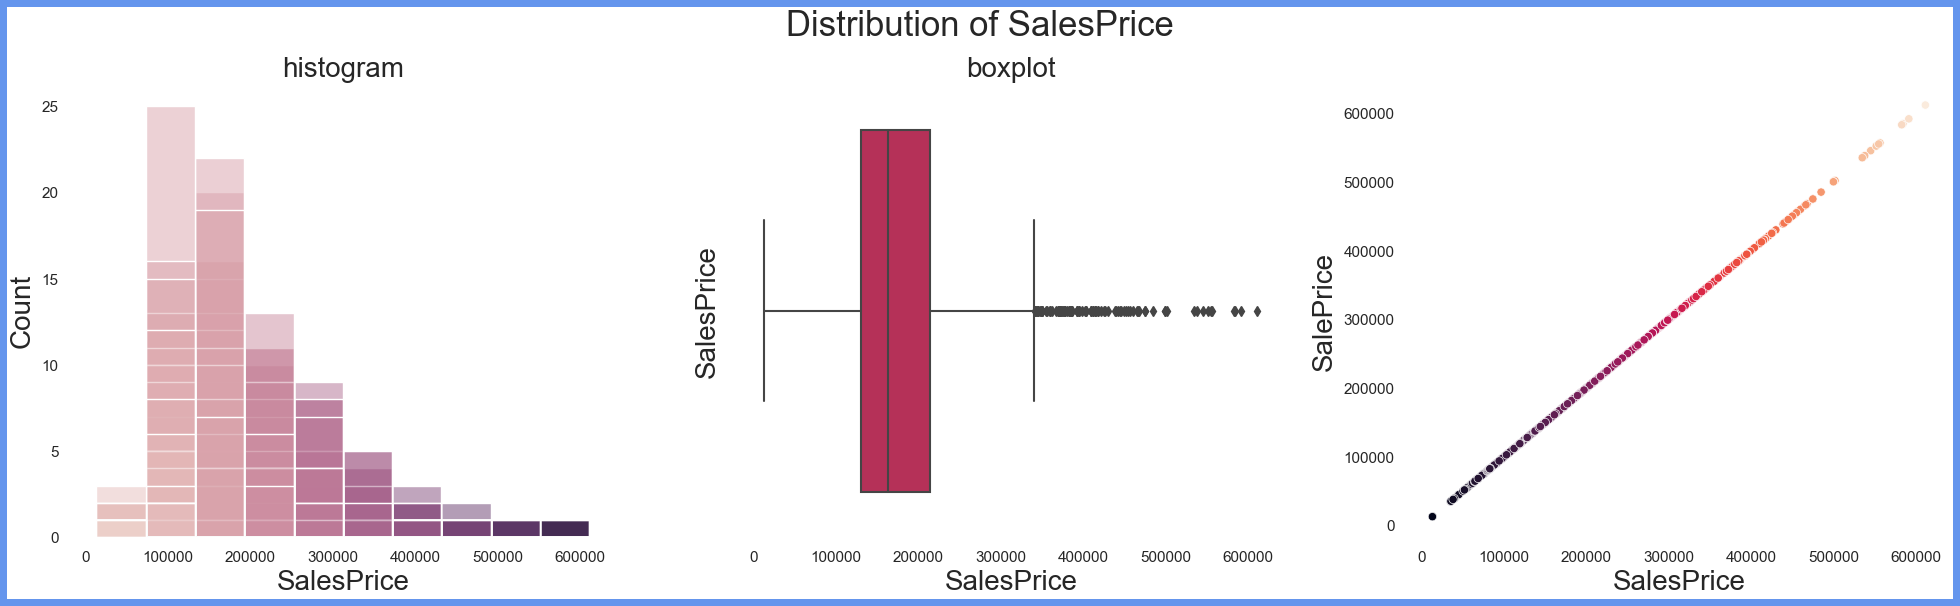

In [51]:
# Check distribution of target variable
univariate_numerical_plot(X_y,'SalesPrice')

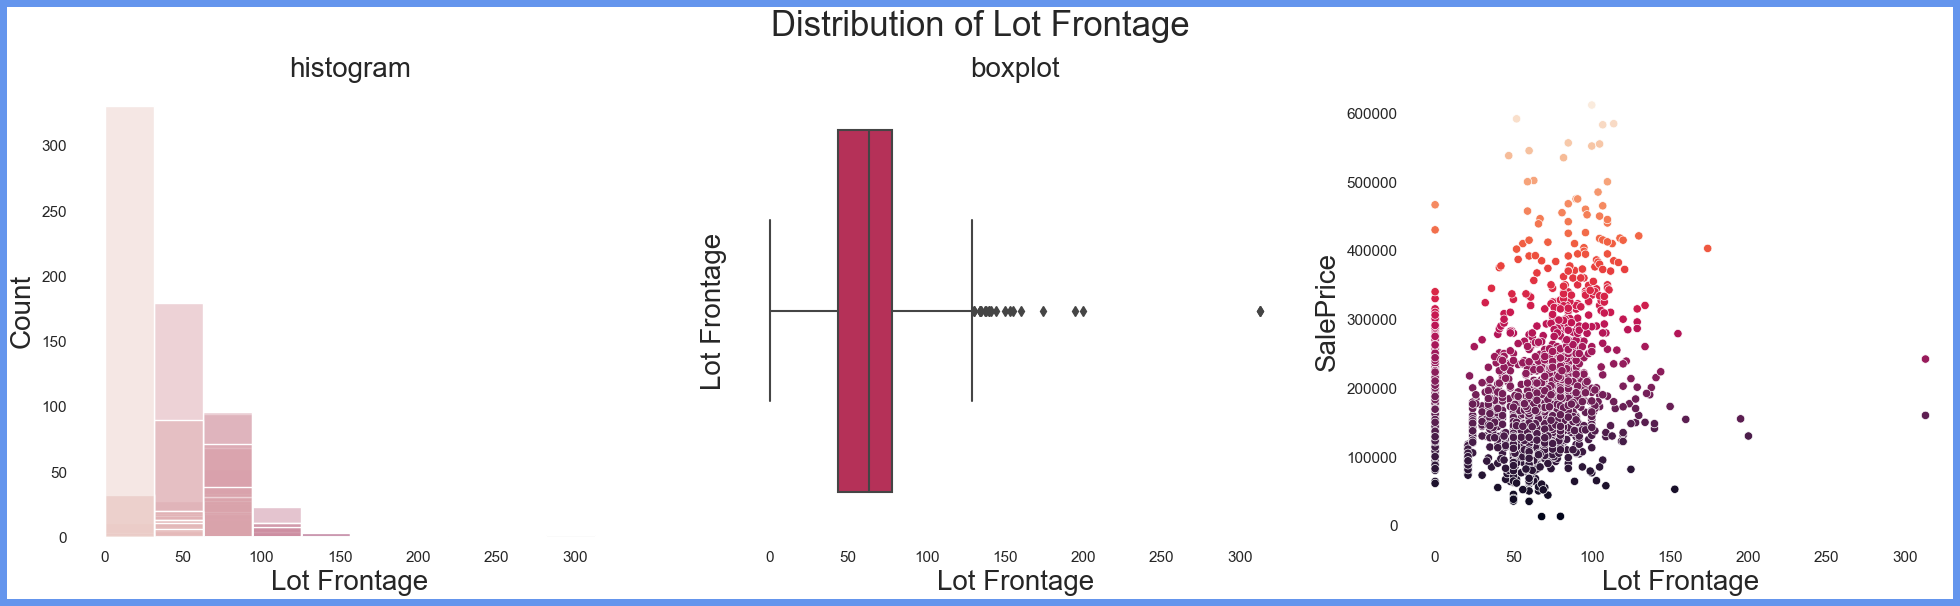

In [52]:
univariate_numerical_plot(X, 'Lot Frontage')

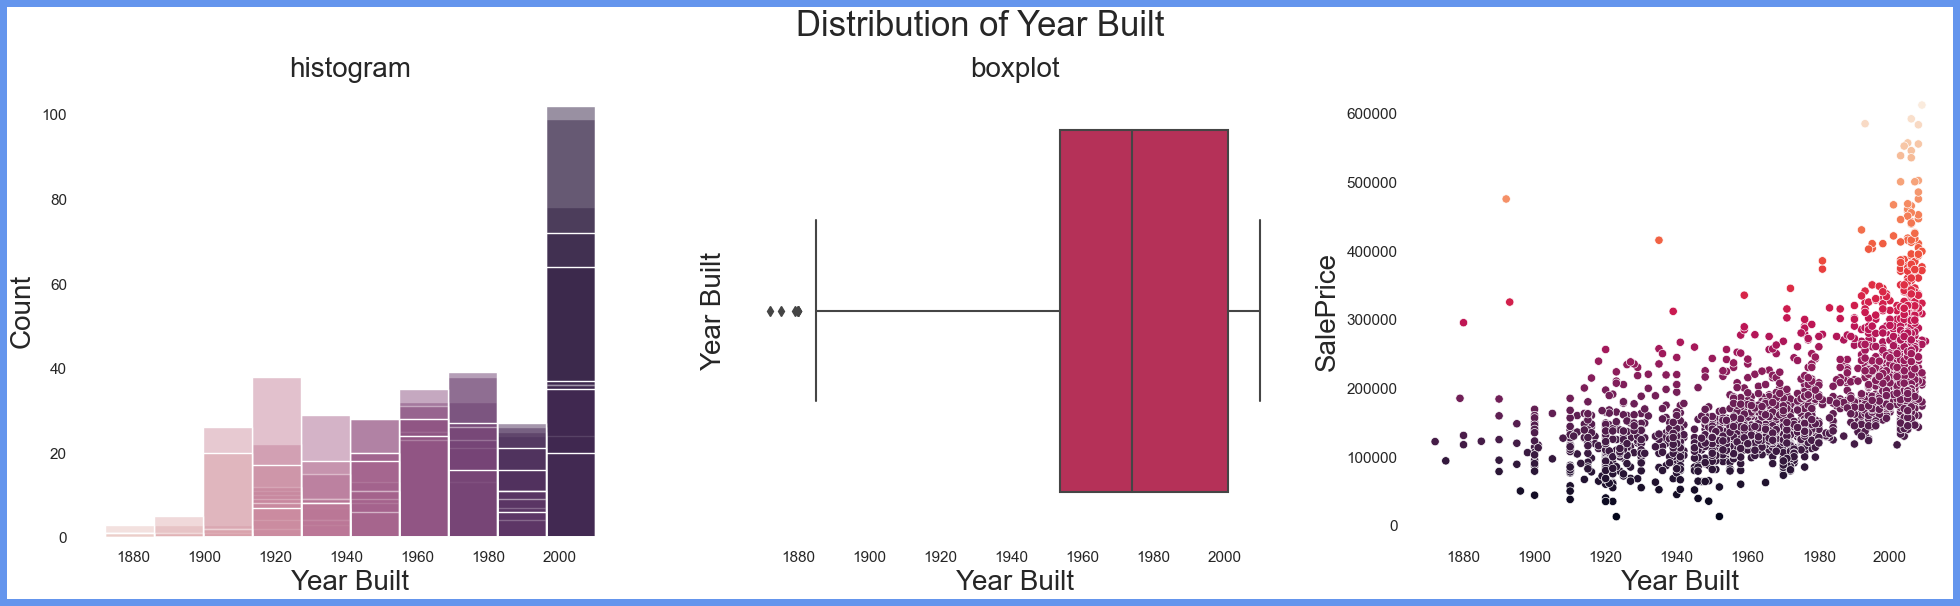

In [53]:
univariate_numerical_plot(X_y, 'Year Built')

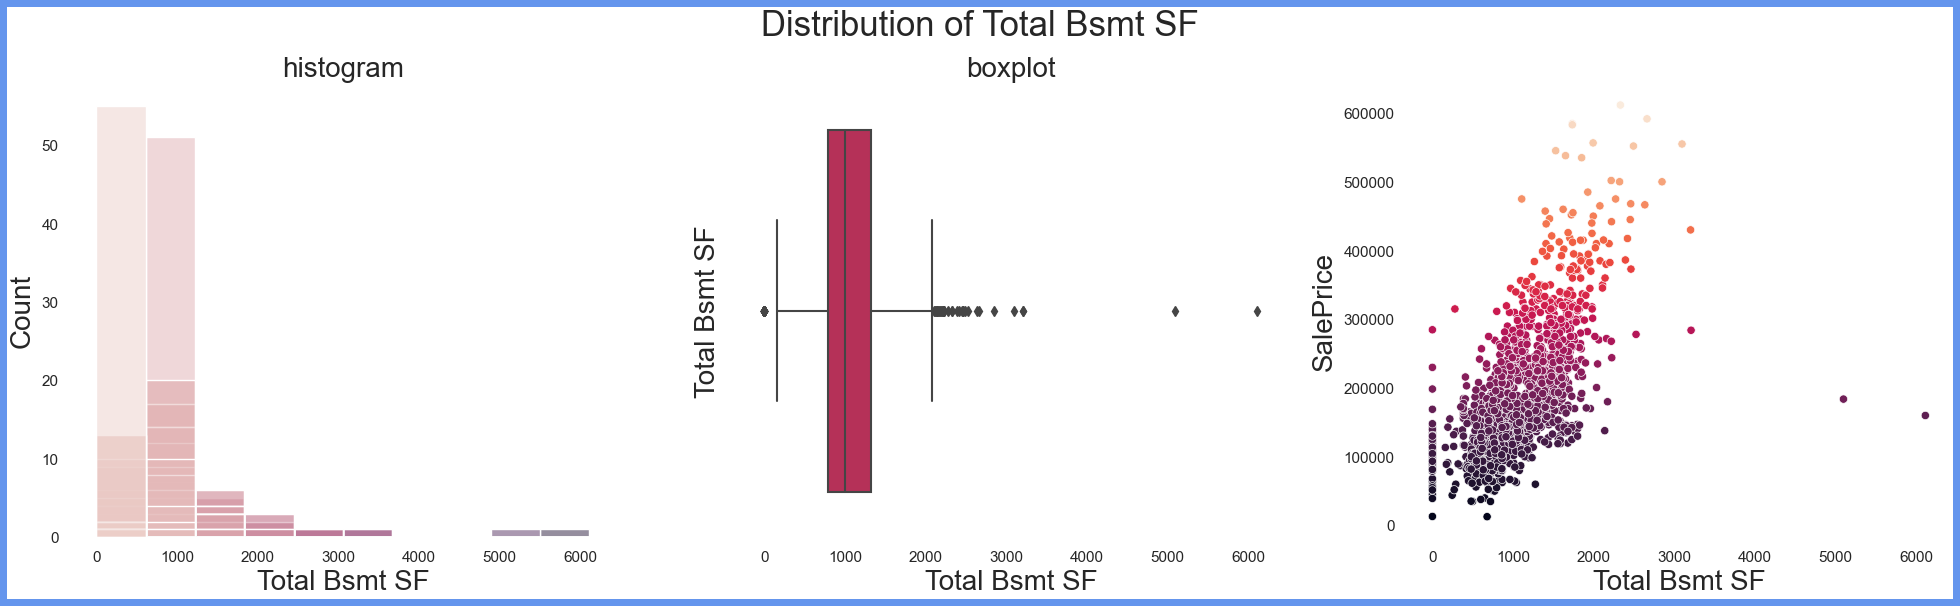

In [54]:
univariate_numerical_plot(X_y, 'Total Bsmt SF')

# 4.1 Correlation of X with y

In [55]:
Linear_Correlation = pd.DataFrame(train.corr())
Linear_Correlation

PID  MS SubClass  Lot Frontage  Lot Area  Overall Qual  \
PID              1.000000    -0.003632     -0.091291  0.024135     -0.265863   
MS SubClass     -0.003632     1.000000     -0.389790 -0.245484      0.035763   
Lot Frontage    -0.091291    -0.389790      1.000000  0.574024      0.194808   
Lot Area         0.024135    -0.245484      0.574024  1.000000      0.105824   
Overall Qual    -0.265863     0.035763      0.194808  0.105824      1.000000   
Overall Cond     0.106861    -0.070141     -0.054455 -0.019185     -0.082770   
Year Built      -0.347039     0.035983      0.109504  0.036002      0.602964   
Year Remod/Add  -0.176666     0.044836      0.085052  0.050771      0.584654   
Mas Vnr Area    -0.247959    -0.004047      0.218218  0.169379      0.438685   
BsmtFin SF 1    -0.086522    -0.060854      0.214178  0.215430      0.278742   
BsmtFin SF 2    -0.013144    -0.068265      0.036740  0.041717     -0.028199   
Bsmt Unf SF     -0.111281    -0.139911      0.127605  0.041184      0.275773   
Total Bsmt SF   -0.203795    -0.226038      0.356584  0.277175      0.548742   
1st Flr SF      -0.145862    -0.246212      0.463900  0.381593      0.477136   
2nd Flr SF      -0.005598     0.305771      0.013700  0.029398      0.228152   
Low Qual Fin SF  0.072268     0.031091     -0.000300  0.001273     -0.052338   
Gr Liv Area     -0.112936     0.068210      0.383856  0.327427      0.566701   
Bsmt Full Bath  -0.030554     0.025055      0.111441  0.116128      0.175171   
Bsmt Half Bath  -0.001946    -0.017249     -0.030858  0.029980     -0.047318   
Full Bath       -0.179370     0.142087      0.152812  0.125601      0.515080   
Half Bath       -0.163975     0.179404      0.035842  0.049995      0.274859   
Bedroom AbvGr    0.009122    -0.003516      0.220414  0.139060      0.053373   
Kitchen AbvGr    0.068416     0.252111      0.015856 -0.013484     -0.170964   
TotRms AbvGrd   -0.084999     0.034490      0.362704  0.238724      0.382025   
Fireplaces      -0.120710    -0.055118      0.253456  0.289467      0.388920   
Garage Yr Blt   -0.251257     0.084954      0.067865  0.004882      0.574553   
Garage Cars     -0.228368    -0.049148      0.297143  0.214954      0.587423   
Garage Area     -0.200891    -0.108228      0.358457  0.263296      0.563814   
Wood Deck SF    -0.041221     0.001622      0.115180  0.155623      0.257081   
Open Porch SF   -0.081129    -0.020289      0.184958  0.140864      0.308855   
Enclosed Porch   0.150179    -0.039842     -0.003302  0.014139     -0.154554   
3Ssn Porch      -0.024679    -0.030088      0.031855  0.019553      0.031938   
Screen Porch    -0.042030    -0.038819      0.074819  0.067714      0.048752   
Pool Area        0.005825    -0.004585      0.156575  0.115102      0.006558   
Misc Val         0.004223    -0.027485      0.051676  0.093922      0.022099   
Mo Sold         -0.032735     0.013027     -0.017389  0.003197      0.019242   
Yr Sold          0.008476    -0.032870      0.009112 -0.029454     -0.011578   
SalePrice       -0.255052    -0.087335      0.341842  0.296566      0.800207   

                 Overall Cond  Year Built  Year Remod/Add  Mas Vnr Area  \
PID                  0.106861   -0.347039       -0.176666     -0.247959   
MS SubClass         -0.070141    0.035983        0.044836     -0.004047   
Lot Frontage        -0.054455    0.109504        0.085052      0.218218   
Lot Area            -0.019185    0.036002        0.050771      0.169379   
Overall Qual        -0.082770    0.602964        0.584654      0.438685   
Overall Cond         1.000000   -0.370988        0.042614     -0.135878   
Year Built          -0.370988    1.000000        0.629116      0.329741   
Year Remod/Add       0.042614    0.629116        1.000000      0.211443   
Mas Vnr Area        -0.135878    0.329741        0.211443      1.000000   
BsmtFin SF 1        -0.045768    0.275440        0.166680      0.321807   
BsmtFin SF 2         0.047810   -0.021031       -0.057163     -0.016756   
B

In [56]:
all_corr = Linear_Correlation.sort_values(by = 'SalePrice', ascending=False) #[-0:6]
correlation = pd.DataFrame(all_corr, columns=['SalePrice'])

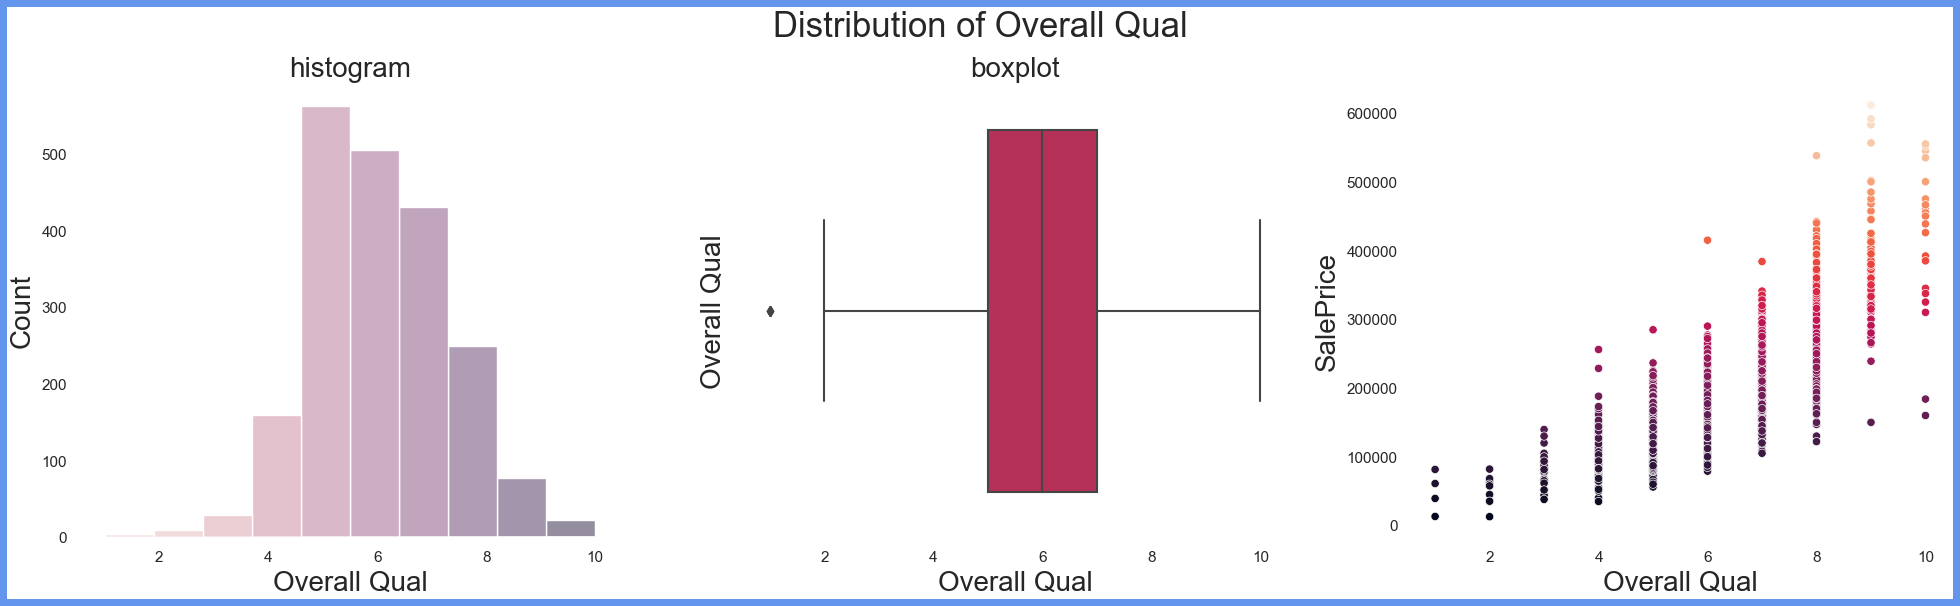

In [57]:
univariate_numerical_plot(X_y, 'Overall Qual')

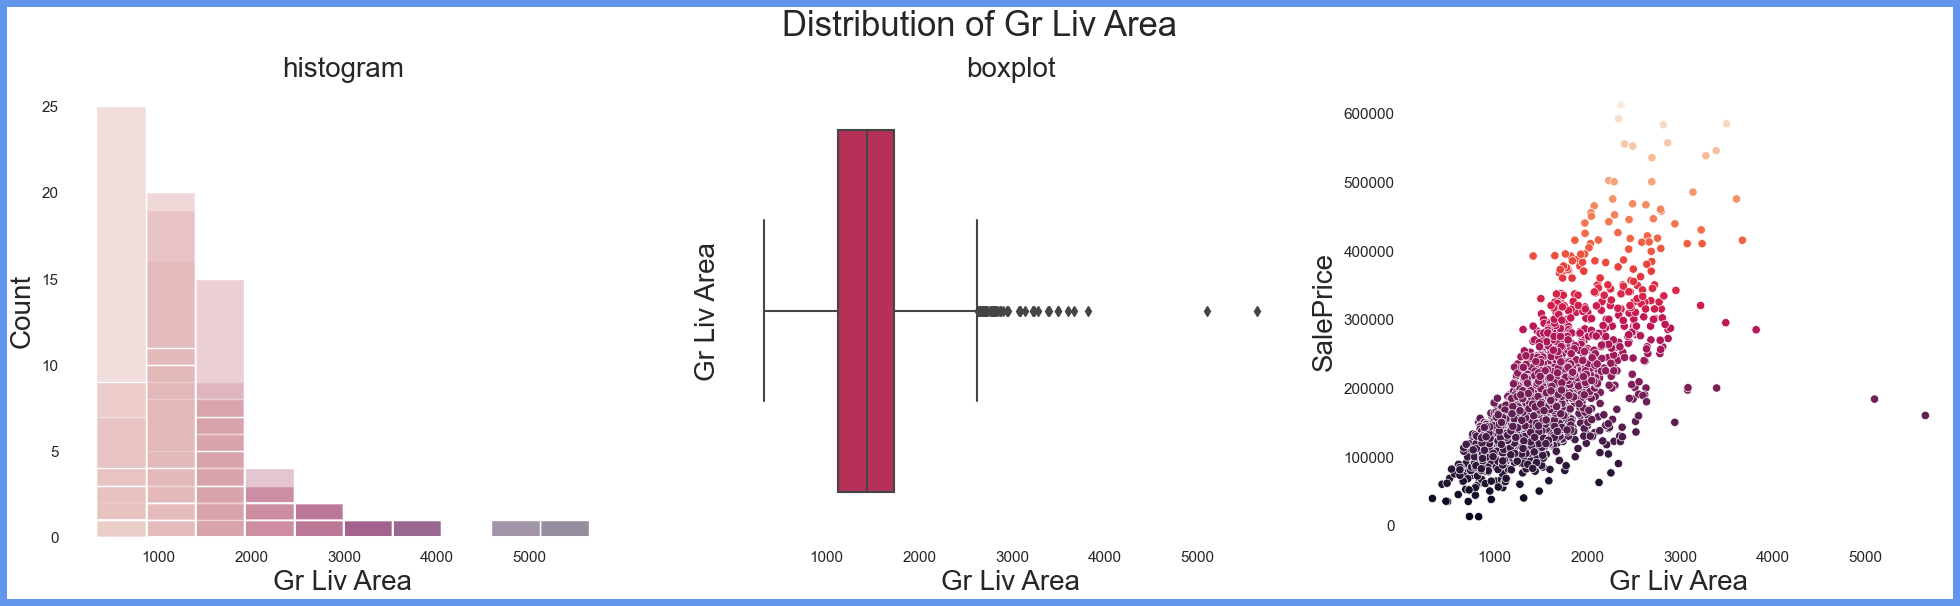

In [58]:
univariate_numerical_plot(X_y, 'Gr Liv Area')

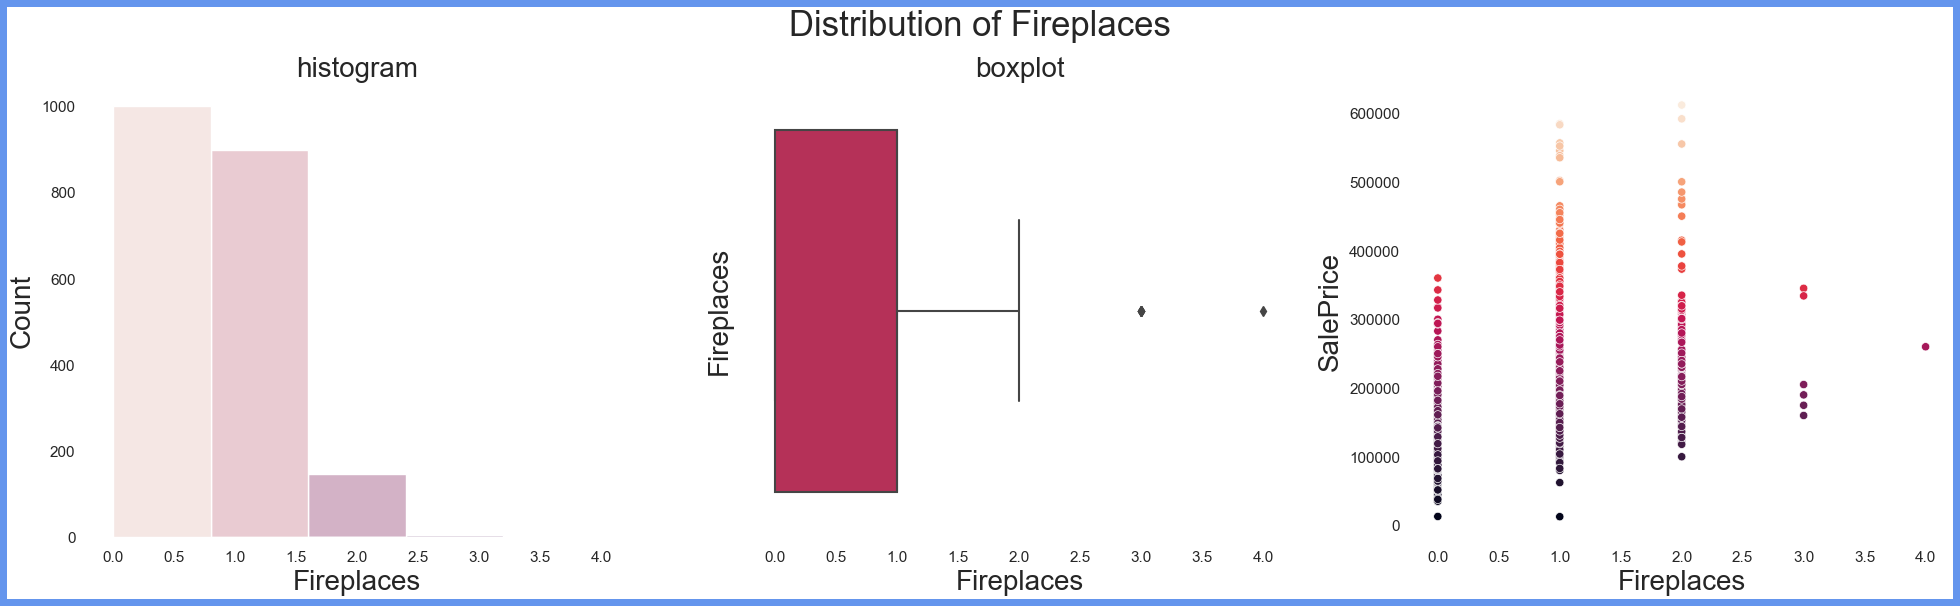

In [59]:
univariate_numerical_plot(X_y, 'Fireplaces')

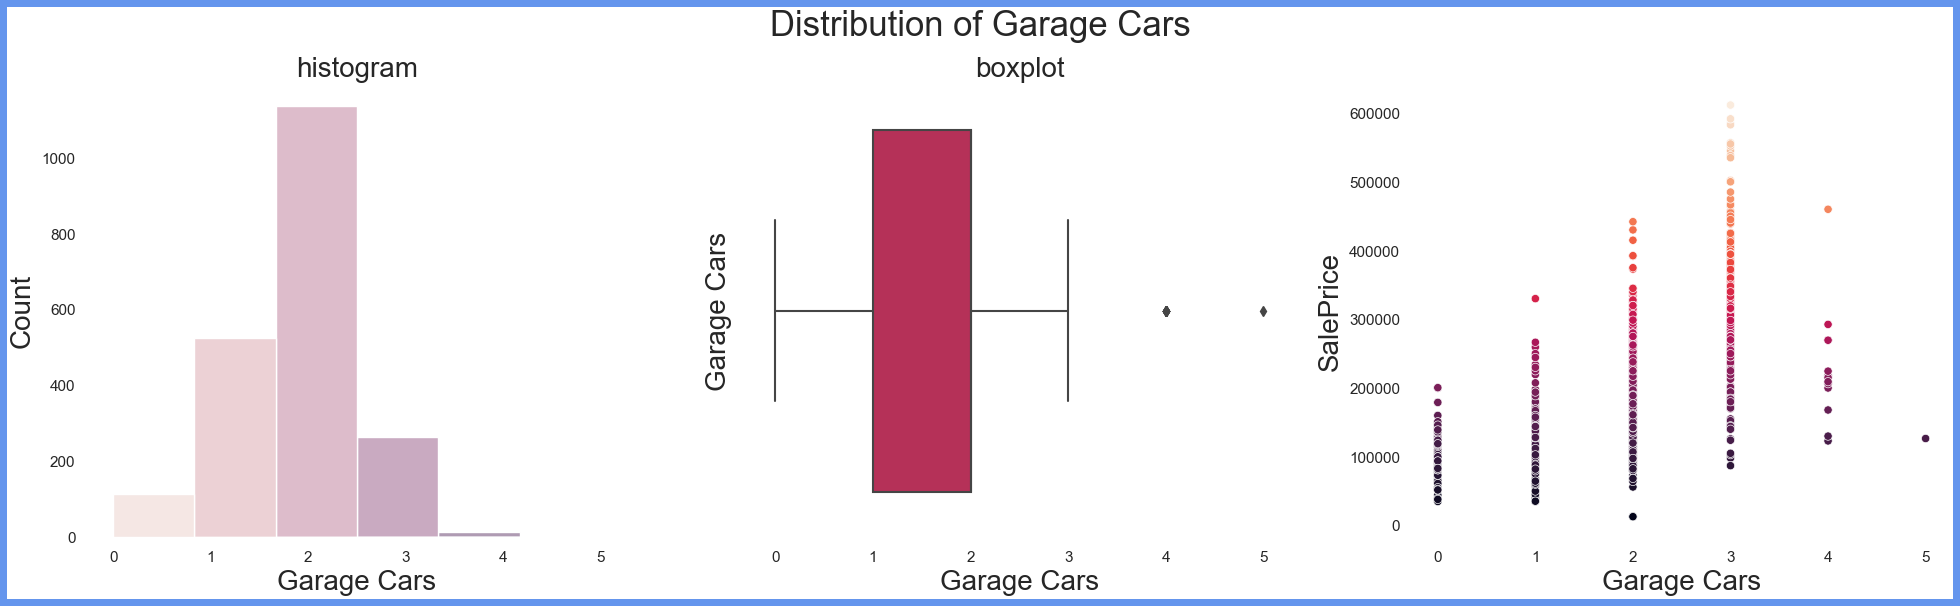

In [60]:
univariate_numerical_plot(X_y, 'Garage Cars')

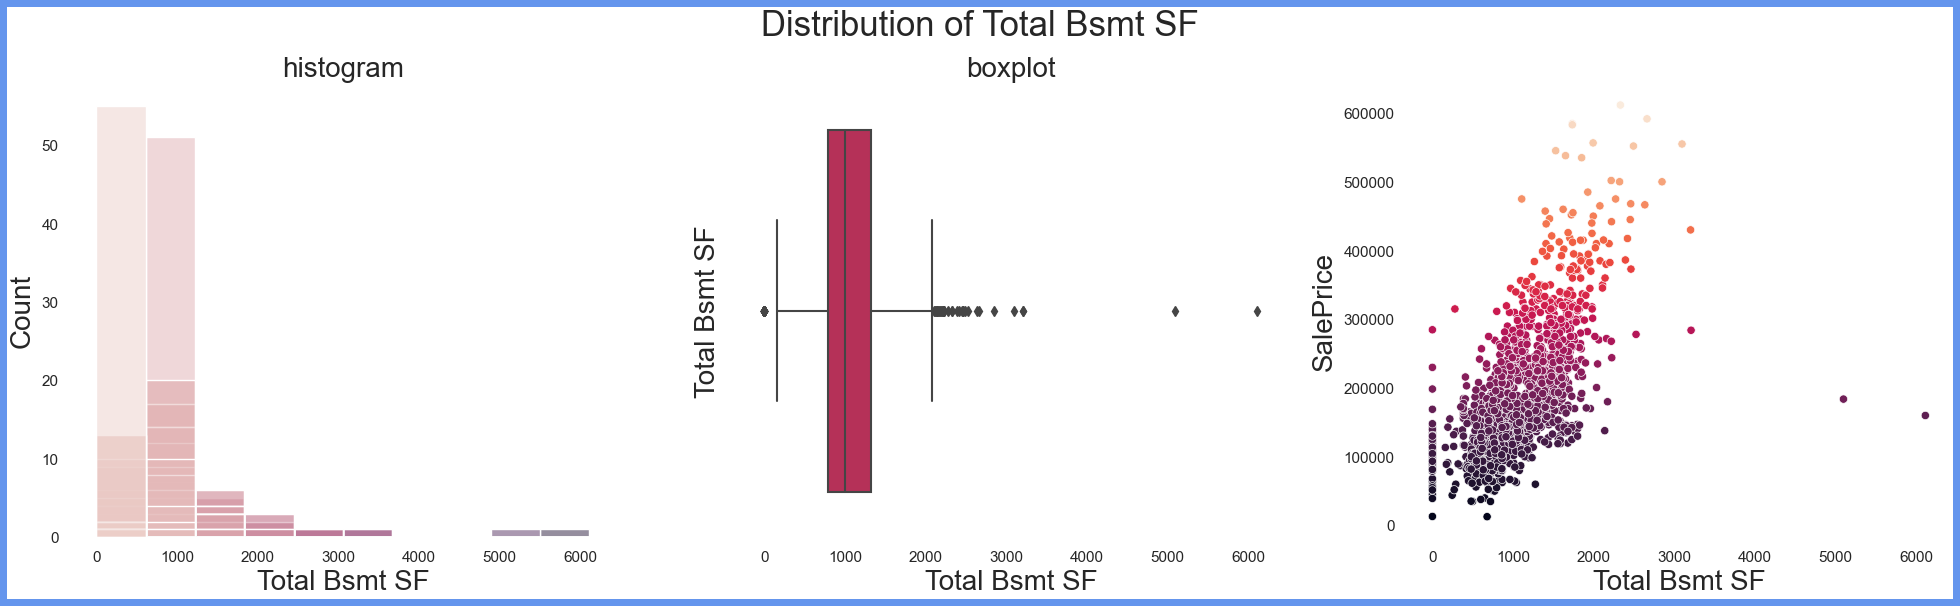

In [61]:
univariate_numerical_plot(X_y, 'Total Bsmt SF')

In [62]:
top_5_corr = pd.DataFrame(all_corr, columns=['SalePrice'])

In [63]:
#Making the correlation thershold score as 0.01
most_relevant_features = top_5_corr[top_5_corr['SalePrice'] > 0.00000001]
most_relevant_features

SalePrice
SalePrice        1.000000
Overall Qual     0.800207
Gr Liv Area      0.697038
Garage Area      0.650270
Garage Cars      0.648220
Total Bsmt SF    0.628925
1st Flr SF       0.618486
Year Built       0.571849
Year Remod/Add   0.550370
Full Bath        0.537969
Garage Yr Blt    0.533922
Mas Vnr Area     0.512230
TotRms AbvGrd    0.504014
Fireplaces       0.471093
BsmtFin SF 1     0.423519
Lot Frontage     0.341842
Open Porch SF    0.333476
Wood Deck SF     0.326490
Lot Area         0.296566
Bsmt Full Bath   0.283662
Half Bath        0.283001
2nd Flr SF       0.248452
Bsmt Unf SF      0.190210
Bedroom AbvGr    0.137067
Screen Porch     0.134581
3Ssn Porch       0.048732
Mo Sold          0.032735
Pool Area        0.023106
BsmtFin SF 2     0.016255

In [64]:
len(most_relevant_features.index)

29

In [65]:
most_relevant_features.index

Index(['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Year Built',
       'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area',
       'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage',
       'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath',
       'Half Bath', '2nd Flr SF', 'Bsmt Unf SF', 'Bedroom AbvGr',
       'Screen Porch', '3Ssn Porch', 'Mo Sold', 'Pool Area', 'BsmtFin SF 2'],
      dtype='object')

<Figure size 1680x2400 with 0 Axes>

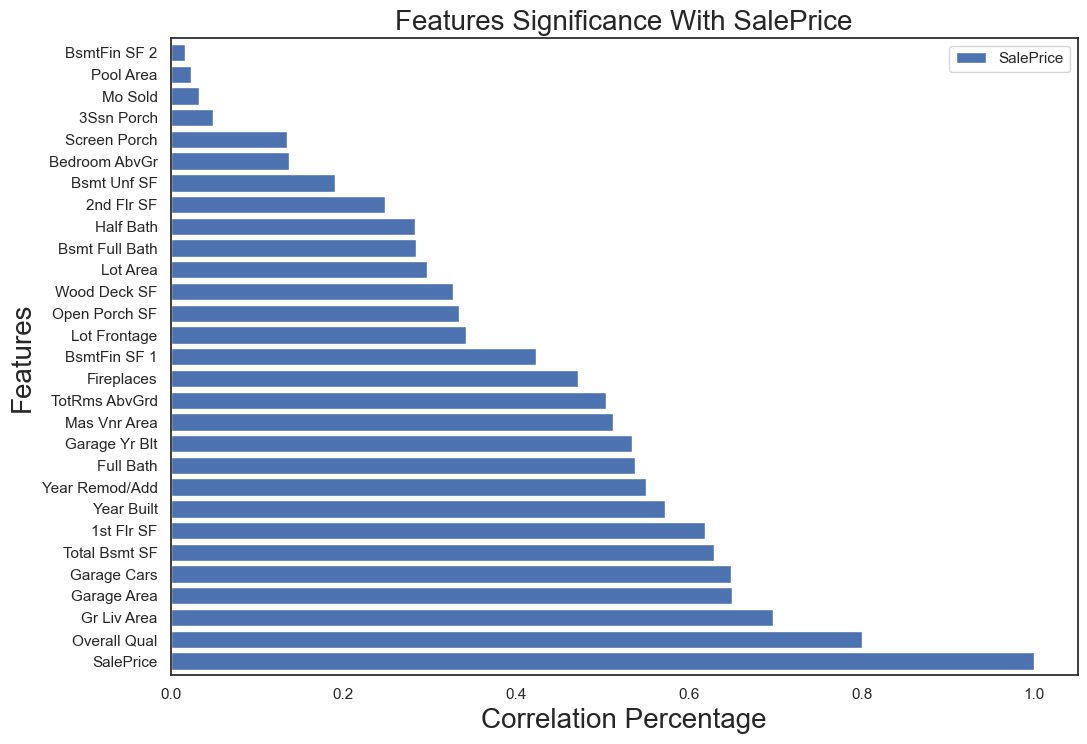

In [66]:
# Plot horizaontal bar plot
plt.figure(figsize=(14,20), dpi=120)
most_relevant_features.plot.barh(width=0.8)
plt.title('Features Significance With SalePrice')
plt.ylabel('Features')
plt.xlabel('Correlation Percentage')
plt.legend()
plt.show();


In [67]:
# sns.barplot(x = Linear_Correlation, y = Linear_Correlation.columns, data = X)

# 6) Model Creation

# 6.1 ) XGBoost Regressor

In [80]:
# Create object of class XGBRegressor
xgb = XGBRegressor(eval_metric='rmse')

In [81]:
#conda install -c conda-forge py-xgboost

In [82]:
import xgboost as xg
from sklearn.model_selection import train_test_split

'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area',
       'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage',
       'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath',
       'Half Bath', '2nd Flr SF', 'Bsmt Unf SF', 'Bedroom AbvGr',
       'Screen Porch', '3Ssn Porch', 'Mo Sold', 'Pool Area', 'BsmtFin SF 2'

In [83]:
##KEY TO CONVERY THE COLUMNS INTO NUMERIC!
X_y = X_y.apply(pd.to_numeric, errors='coerce')

In [84]:
features = X_y[['Overall Qual', 'Gr Liv Area', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area',
       'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage',
       'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath',
       'Half Bath', '2nd Flr SF', 'Bsmt Unf SF', 'Bedroom AbvGr',
       'Screen Porch', '3Ssn Porch', 'Mo Sold', 'Pool Area', 'BsmtFin SF 2']]

X = features
y = X_y['SalesPrice']

In [85]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

In [86]:
xgb = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)

In [87]:
xgb.fit(X_train, y_train)

[16:36:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [88]:
# Train score
xgb.score(X_train, y_train)

0.9640374484163868

In [89]:
# Test score
xgb.score(X_test, y_test)

0.8754635029305653

# 6.2 ) GridSearch !

In [90]:
param_grid = [
    {'subsample': [0.5], 'n_estimators': [1400], 
     'max_depth': [5], 'learning_rate': [0.02],
     'colsample_bytree': [0.4], 'colsample_bylevel': [0.5],
     'reg_alpha':[1], 'reg_lambda': [1], 'min_child_weight':[2]}
]
grid_search = GridSearchCV(xgb, param_grid, cv=3, verbose=1, scoring='neg_root_mean_squared_error')

In [91]:
grid_search.fit(X, np.log(y));

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[16:36:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [92]:
# Top 5 hyper-parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results.sort_values('rank_test_score')[:6])

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.602299       0.23837         0.007518        0.000012   

  param_colsample_bylevel param_colsample_bytree param_learning_rate  \
0                     0.5                    0.4                0.02   

  param_max_depth param_min_child_weight param_n_estimators param_reg_alpha  \
0               5                      2               1400               1   

  param_reg_lambda param_subsample  \
0                1             0.5   

                                              params  split0_test_score  \
0  {'colsample_bylevel': 0.5, 'colsample_bytree':...          -0.148191   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           -0.12987          -0.146717        -0.141593        0.008311   

   rank_test_score  
0                1

In [93]:
grid_search.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 0.4,
 'learning_rate': 0.02,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 1400,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.5}

In [94]:
print("RMSLE on training data:",round(-grid_search.score(X, np.log(y)),4))
print("RMSLE on validation data:",round(-grid_search.best_score_,4))

RMSLE on training data: 0.0927
RMSLE on validation data: 0.1416


In [95]:
y_preds = np.exp(grid_search.predict(X_test))

In [96]:
mean_squared_error(y_test, y_preds, squared=False)

15047.011490409179

In [97]:
scores = cross_val_score(estimator=xgb, X=X, y=y, cv=5)

[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [98]:
cross_val_score(xgb, X_train, y_train, cv=5).mean()

[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


0.8516455580496254

In [99]:
scores.mean()

0.8642551143287708

In [100]:
scores.std()

0.020780707459569638

In [101]:
# Training RMSE
print('train:', mean_squared_error(y_train, xgb.predict(X_train), squared=False))

# Testing RMSE
print('test:', mean_squared_error(y_test, xgb.predict(X_test), squared=False))

train: 15225.986282366306
test: 27187.465301134987


In [102]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': y_preds.round()})
output.to_csv('submission.csv', index=False)

In [103]:
output.sample(2)

Id  SalePrice
468  2118   195144.0
509  1256   107157.0

# 6.3 ) Pipeline ( Standard Scaler > Polynomial > RFE > Ridge Regression)

In [139]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [140]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV

In [141]:
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(), RFE(Ridge()), Ridge(max_iter=10_000))

In [142]:
X_y.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage

In [143]:
features = X_y[['Overall Qual', 'Gr Liv Area', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area',
       'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage',
       'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath',
       'Half Bath', '2nd Flr SF', 'Bsmt Unf SF', 'Bedroom AbvGr',
       'Screen Porch', '3Ssn Porch', 'Mo Sold', 'Pool Area', 'BsmtFin SF 2']]

X = features
y = X_y['SalesPrice']

In [144]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

In [145]:
X_train.shape

(1374, 27)

In [146]:
X_test.shape

(677, 27)

In [147]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('rfe', RFE(estimator=Ridge())),
                ('ridge', Ridge(max_iter=10000))])

In [148]:
pipe.score(X_train, y_train)

0.944288033442123

In [149]:
pipe.score(X_test, y_test)

0.8524112360319501

In [150]:
from sklearn.model_selection import cross_val_score

In [151]:
scores = cross_val_score(estimator=pipe, X=X, y=y, cv=5)

In [152]:
cross_val_score(pipe, X_train, y_train, cv=5).mean()

0.6575598153395552

In [153]:
scores.mean()

0.7209410839374388

In [154]:
scores.std()

0.14152908725527613

# Grid Search! (For Pipeline)

In [155]:
sscaler = StandardScaler()

In [156]:
sscaler.fit(X_train)

StandardScaler()

In [157]:
X_train_scaled = sscaler.fit_transform(X_train)
#this is supposed to be unknown -- so we don't include
#to compute the mean and standard deviation
X_test_scaled = sscaler.transform(X_test)

In [158]:
params = {'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}

In [159]:
ridge_grid = GridSearchCV(pipe, param_grid=params)

In [160]:
ridge_grid

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('ridge', Ridge(max_iter=10000))]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]})

In [161]:
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('ridge', Ridge(max_iter=10000))]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]})

In [162]:
ridge_grid.score(X_train_scaled, y_train)

0.9431567275757873

In [163]:
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('ridge', Ridge(max_iter=10000))]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]})

In [164]:
ridge_grid.score(X_train_scaled, y_train)

0.9431567275757873

In [165]:
ridge_grid.cv_results_

{'mean_fit_time': array([0.89830413, 0.82639728, 0.83759794, 0.82168655, 0.82994862]),
 'std_fit_time': array([0.07132154, 0.00529278, 0.01415068, 0.00640629, 0.00975079]),
 'mean_score_time': array([0.00202608, 0.00193238, 0.00198178, 0.00196362, 0.0020762 ]),
 'std_score_time': array([2.48931970e-04, 5.07908802e-05, 4.68336630e-05, 3.87724618e-05,
        1.59376456e-04]),
 'param_ridge__alpha': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge__alpha': 0.001},
  {'ridge__alpha': 0.01},
  {'ridge__alpha': 0.1},
  {'ridge__alpha': 1.0},
  {'ridge__alpha': 10.0}],
 'split0_test_score': array([0.79537814, 0.79636472, 0.79837328, 0.80449072, 0.83507554]),
 'split1_test_score': array([0.7629506 , 0.77012687, 0.78097017, 0.78844839, 0.80127133]),
 'split2_test_score': array([0.36478163, 0.37642101, 0.47815553, 0.70868797, 0.81422802]),
 'split3_test_score': array([

In [166]:
ridge_grid.best_estimator_.named_steps['ridge'].predict

<bound method LinearModel.predict of Ridge(alpha=10.0, max_iter=10000)>

In [167]:
pipe.named_steps['ridge'].coef_

array([ 22040.90321632,   6459.77408912,  -2061.29633588,   7614.08023243,
        14076.43927324,   9865.82385358,  13072.85033049,   3137.3002094 ,
        24518.36924666,   2697.6263318 ,   3908.53440132,   9864.99707746,
         1295.86625527,   2806.56082292,   8799.18519254,   6224.93067848,
        10688.22109011,  -3144.8450783 ,   4834.53048115,   1455.0867011 ,
         4971.10981669,   2820.93775061,   6787.63214142,  -2099.05447682,
        -2307.66479263,   6637.26215812,  -3162.25053304,   2520.77873314,
         2069.0733382 ,  -6594.39487978,   5206.23778425,   8272.58059061,
         1386.80239538,   1649.03493843,  -4151.55703823,  -4512.05296581,
        12220.30644538,  -5167.14759746,   9177.34274184,  -2452.25354281,
        -2425.35180426,   9479.98180106,   7926.87945447,  -8319.56320185,
         7476.18009063,   1414.2806755 ,  -6871.18381763,   7330.24998174,
        -5015.39957738,  -2763.79363846,  10548.31662392,  -2038.39783911,
        -7090.47637276,  

In [168]:
y_preds2 = ridge_grid.predict(X_test_scaled)

In [169]:
output2 = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': y_preds2.round()})
output2.to_csv('submission_byPipeline_Scaler_Lasso_Ridge.csv', index=False)

In [170]:
output2.head()

Id  SalePrice
0  2782   126231.0
1  2569   214346.0
2  1062   269258.0
3   287   114553.0
4  2809   196396.0

In [171]:
# Training MSE
#from sklearn.metrics import mean_squared_error
#from sklearn import metrics

#mean_squared_error(y_train, pipe.predict(X_train))

In [172]:
# Testing MSE
#mean_squared_error(y_test, pipe.predict(X_test))

In [173]:
# Training MSE
print('train:', mean_squared_error(y_train, ridge_grid.predict(X_train_scaled), squared=False))

# Testing RMSE
print('test:', mean_squared_error(y_test, ridge_grid.predict(X_test_scaled), squared=False))

train: 19142.546963963865
test: 28631.799465502743


In [174]:
ridge_grid.score(X_train_scaled, y_train)

0.9431567275757873

In [175]:
ridge_grid.score(X_test_scaled, y_test)

0.8618800243644766

In [176]:
coef = dict(zip(X_train.columns, ridge_grid.best_estimator_.named_steps['ridge'].coef_))
coef = {k: v for k, v in sorted(coef.items(), key=lambda item: item[1])}

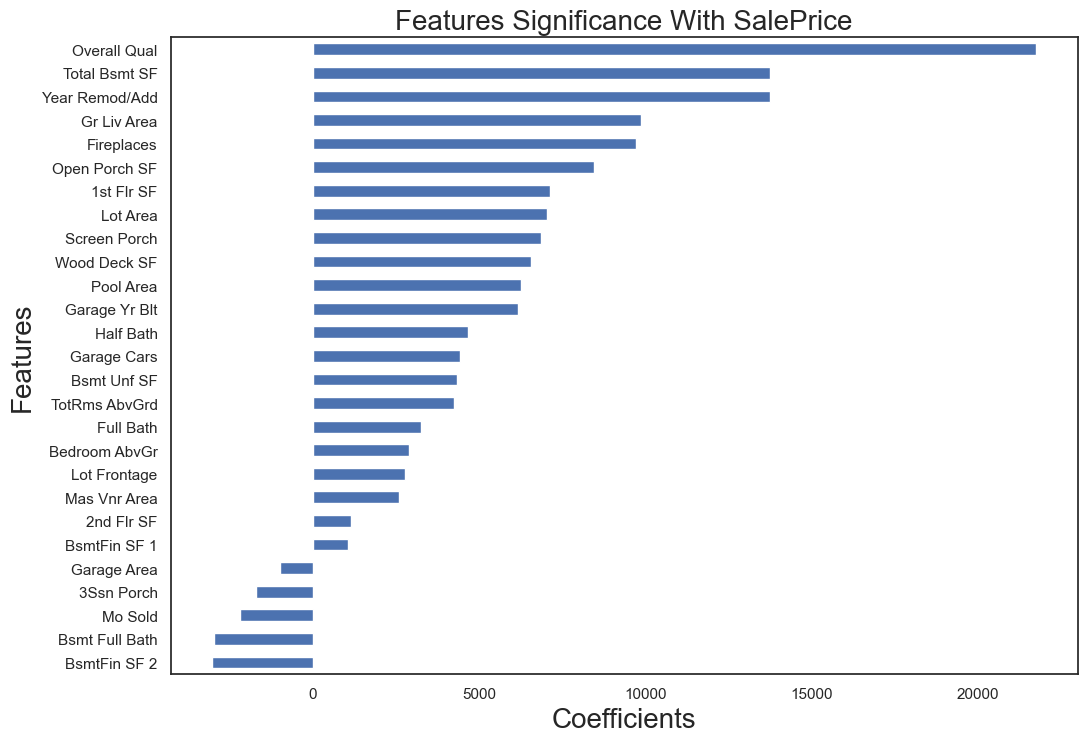

In [177]:
pd.Series(coef).plot(kind = 'barh')
plt.title('Features Significance With SalePrice')
plt.ylabel('Features')
plt.xlabel('Coefficients')
plt.show();


# 6.3 ) Pipeline ( Polynomial Feature -> Standard Scaler -> Linear Regression)
# (Testing purpose only)

In [396]:
features = X_y[['Overall Qual', 'Gr Liv Area', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', '1st Flr SF']]

X = features
y = X_y['SalesPrice']

In [397]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

In [398]:
pipe2 = make_pipeline(PolynomialFeatures(), StandardScaler(), LinearRegression())

In [399]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [400]:
pipe2.score(X_train, y_train)

0.8640719312266586

In [401]:
pipe2.score(X_test, y_test)

0.8589086151230839

In [402]:
scores = cross_val_score(estimator=pipe2, X=X, y=y, cv=3)

In [403]:
cross_val_score(pipe2, X_train, y_train, cv=5).mean()

0.8241093775785184

In [404]:
scores.mean()

0.8451234176959926

In [405]:
scores.std()

0.016675415288889342

In [417]:
# Training RMSE
print('train:', mean_squared_error(y_train, pipe2.predict(X_train), squared=False))

# Testing RMSE
print('test:', mean_squared_error(y_test, pipe2.predict(X_test), squared=False))


train: 29601.570880029016
test: 28938.14212272259


# Linear Regression (testing purpose only)

In [407]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [408]:
# Train score
lr.score(X_train, y_train)

0.7568660757987792

In [409]:
# Test score
lr.score(X_test, y_test)

0.8240596515423363

In [410]:
pd.DataFrame({'feature': X.columns, 'coef': lr.coef_})

feature          coef
0   Overall Qual  25473.232254
1    Gr Liv Area     39.760046
2    Garage Area     21.451339
3    Garage Cars  12377.123075
4  Total Bsmt SF     17.986567
5     1st Flr SF     14.076786

In [411]:
print(f'intercept:', lr.intercept_)

intercept: -101352.86070994273


In [412]:
y_preds3 = lr.predict(X_test)

In [413]:
# Training RMSE
print('train:', mean_squared_error(y_train, lr.predict(X_train), squared=False))

# Testing RMSE
print('test:', mean_squared_error(y_test, lr.predict(X_test), squared=False))

train: 39589.768762170694
test: 32314.92266997577


In [414]:
scores = cross_val_score(estimator=pipe2, X=X, y=y, cv=3)

In [415]:
cross_val_score(pipe2, X_train, y_train, cv=5).mean()

0.8241093775785184

In [416]:
cross_val_score(pipe2, X_train, y_train, cv=5).mean()

0.8241093775785184

# Baseline

In [127]:
y.mean()

181469.70160897123